In [ ]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'store-sales-time-series-forecasting:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F29781%2F2887556%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240915%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240915T101512Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D2dc9f8d7f459353bb9b5e04258e8c3bd2b7c083e5c545fd4b0ca8e660dc4a0487d5316558b31d1613279549c94f2d4d9d49570f63a27f14ea6088f4ab232dee92ce1ebbb775691fbbfdadba9bbb4a0e65d18723cb7a8cd398265484bb20923435168541d8f1dee0acd9a45ec91273a7f0b246bdd513fd10a1aaa1d4f43843348920bf9b1d0eb9239b302596550e1db671d125603cf55fbb66f0ffba69f103afc25aa034bf73d7879c176e623fd8e9c1b65facef0d4f2efec3253de51b327ea7302aa5c5664ea3c8fcfa9b84995bffdd9af23bb9c00b88ce28007fee03479450caa97cb80f8e8093ad69508c69fbd1600baf7a98206d63de720a1dd5d0c2b682e'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')

# Data Preprocessing and Feature Engineering

## Source Data Loading

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as ss
! pip install sktime pmdarima pytorch-lightning
import pytorch_lightning as pl

pd.set_option('display.max_columns', None)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', message='Level of selected dummy variable  lower level than base ts_frequency.')

SEED = 42

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.9/23.9 MB 49.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 70.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 10.3 MB/s eta 0:00:00


In [ ]:
KAGGLE_INPUT_PATH= '/kaggle/input/store-sales-time-series-forecasting'
KAGGLE_WORKING_PATH = '/kaggle/working'

In [ ]:
dtypes = {
    'sales': float,
    # train and test
    'date': str,
    'store_nbr': int,
    'family': 'category',
    'onpromotion': int,
    # oil - date
    'dcoilwtico': float,
    # holiday - date
    'type': 'category',
    'locale': 'category',
    'locale_name': 'string',
    'description': 'string',
    'transferred': bool,
    # store - store_nbr
    'city': 'category',
    'state': 'category',
    'cluster': 'category',
    # transactions - date and store_nbr
    'transactions': int
}

df_train = pd.read_csv(os.path.join(KAGGLE_INPUT_PATH, 'train.csv'),
                       dtype=dtypes)
families = list(df_train.family.cat.categories)
print(families)
stores = list(df_train.store_nbr.unique())
print(stores)
df_test = pd.read_csv(os.path.join(KAGGLE_INPUT_PATH, 'test.csv'),
                      dtype=dtypes)
print(f'Found {len(df_train)} rows for training and {len(df_test)} rows for testing')
df_oil = pd.read_csv(os.path.join(KAGGLE_INPUT_PATH, 'oil.csv'),
                       dtype=dtypes)
df_oil.rename(columns={'dcoilwtico': 'oil_price'}, inplace=True)
df_holy = pd.read_csv(os.path.join(KAGGLE_INPUT_PATH, 'holidays_events.csv'),
                       dtype=dtypes)
df_holy.rename(columns={'type': 'holiday_type'}, inplace=True)
df_store = pd.read_csv(os.path.join(KAGGLE_INPUT_PATH, 'stores.csv'),
                       dtype=dtypes)
df_store.rename(columns={'type': 'store_type'}, inplace=True)
df_trans = pd.read_csv(os.path.join(KAGGLE_INPUT_PATH, 'transactions.csv'),
                       dtype=dtypes)
df_sample = pd.read_csv(os.path.join(KAGGLE_INPUT_PATH, 'sample_submission.csv'))
df_sample.head()

# transform store_nbr as categorical starting from zero
for df in [df_train, df_test, df_store, df_trans]:
  df['store_nbr'] = pd.Categorical(df['store_nbr'] - 1)
stores = sorted(list(df_train.store_nbr.cat.categories))

# transform date to datetime
for df in [df_train, df_test, df_oil, df_holy, df_trans]:
  df['date'] = pd.to_datetime(df['date'])

['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS', 'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS', 'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE', 'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES', 'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE', 'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE', 'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY', 'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES', 'SEAFOOD']
[1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 2, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 3, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 4, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 5, 50, 51, 52, 53, 54, 6, 7, 8, 9]
Found 3000888 rows for training and 28512 rows for testing


## Prepare Sales and Onpromotion Data

In [ ]:
from sklearn.preprocessing import MinMaxScaler

def sort_df(df):
  return df.sort_values(by=['date', 'store_nbr'])

def pivot_family_columns(df):
  index = ['date', 'store_nbr']
  onpromotion = df.pivot_table(index=index, columns='family', values='onpromotion',
                                   aggfunc='sum', sort=False).reset_index()
  if 'sales' in df.columns:
    col_pred = 'sales'
  else:
    df = df.reset_index()
    col_pred = 'id'
  pred = df.pivot_table(index=index, columns='family', values=col_pred,
                             aggfunc='sum', sort=False).reset_index()
  df = pd.merge(onpromotion, pred, on=index, suffixes=('_onpromotion', f'_{col_pred}'))
  df.columns.name = None
  return sort_df(df)

def get_sum_of_scaled_sales(df_sales):
  scaler = MinMaxScaler()
  # Apply MinMax scaling to each sales column before adding them up
  scaled_sales = scaler.fit_transform(df_sales)
  return scaled_sales.sum(axis=1)

# Define the final df_train reference
# from this point on the Notebook is immutable on df_train and df_test
df_train = pivot_family_columns(df_train)
sales_columns = [col for col in df_train.columns if col.endswith('_sales')]
df_train['sales_MM'] = get_sum_of_scaled_sales(df_train[sales_columns])
df_test = pivot_family_columns(df_test)
id_columns = [col for col in list(df_test.columns) if col.endswith('_id')]
onpromotion_columns = [col for col in df_train.columns if col.endswith('_onpromotion')]

### Pipeline: Preprocess Onpromotion and Sales Per Store and Product Family

In [ ]:
from pmdarima.utils import diff, diff_inv
from sklearn.preprocessing import MinMaxScaler, PowerTransformer

class StorewiseTransformer:
  # assumes that incoming data is sorted as date, store_nbr
  # returns in order date, store_nbr
  def __init__(self, product_families: list[str],
               diff_period: int, lag_period: int,
               apply_power: bool, apply_scaling: bool):
      self.product_families = product_families
      self.groupby_column = 'store_nbr'
      if apply_power:
        self.power_transformers = {}
      else:
        self.power_transformers = None
      if apply_scaling:
        self.scalers = {}
      else:
        self.scalers = None
      self.diff_period = diff_period
      self.apply_diff = diff_period > 0
      if self.apply_diff:
        self.diff_last_known = {}
        self.train_shifted = {}
      else:
        self.diff_last_known = None
        self.train_shifted = None
      self.lag_period = lag_period
      self.derive_lags = lag_period > 0
      if self.derive_lags:
        self.lag_last_known = {}
        self.feat_lag = [f'{col}_{lag_period}' for col in product_families]
      else:
        self.lag_last_known = None
        self.feat_lag = []

  def _combine_group_data(self, df_list):
      return pd.concat(df_list).sort_values(
          by=['date', self.groupby_column])

  def _fit_transform_power(self, store, group):
    power_transformers = {}
    self.power_transformers[store] = power_transformers
    for family in self.product_families:
      sales = group[family].values
      if np.all(sales == sales[0]):
        transformer = sales[0]
        sales = 0.0
      else:
        transformer = PowerTransformer(standardize=False)
        sales = sales.reshape(-1, 1)
        transformer.fit(sales)
        lmbda = transformer.lambdas_[0]
        if lmbda < 1e-2: # stick to log-transform
          transformer.lambdas_[0] = 0
        sales = transformer.transform(sales)
      power_transformers[family] = transformer
      group[family] = sales

  def _transform_power(self, store, group):
    power_transformers = self.power_transformers[store]
    for family in self.product_families:
      transformer = power_transformers[family]
      if isinstance(transformer, (np.int64, float)):
        group[family] = 0.0
      else:
        group[family] = transformer.transform(
            group[family].values.reshape(-1, 1))

  def _inverse_transform_power(self, store, group):
    power_transformers = self.power_transformers[store]
    for family in self.product_families:
      transformer = power_transformers[family]
      if isinstance(transformer, (np.int64, float)):
        sales = transformer
      else:
        sales = transformer.inverse_transform(
            group[family].values.reshape(-1, 1))
      group[family] = sales

  def _fit_transform_differencing(self, store, group):
    families, period = self.product_families, self.diff_period
    group_shifted = group.copy()
    group_shifted[families] = group[families].shift(periods=period)
    self.train_shifted[store] = group_shifted
    self.diff_last_known[store] = group[families].iloc[-period:].copy()
    group.iloc[-period:, group.columns.get_loc(
        'is_used_for_diff_lag')] = True
    padded_ts = np.vstack((np.zeros((period, len(families))),
                                group[families].values))
    for ts, family in zip(padded_ts.T, families):
      group[family] = diff(ts, lag=period)

  def _transform_differencing_unseen(self, store, group):
    last_and_new = np.vstack((self.diff_last_known[store].values, # num period rows
                              group[self.product_families].values))
    for ts, family in zip(last_and_new.T, self.product_families):
      group[family] = diff(ts, lag=self.diff_period)

  def _inverse_transform_differencing_training(self, store, group):
    group_shifted = self.train_shifted[store]
    group_shifted = group_shifted[group_shifted.date.isin(group.date)]
    group[self.product_families] = group[self.product_families].values + group_shifted[self.product_families].values

  def _inverse_transform_differencing_unseen(self, store, group):
    last_and_new = np.vstack((self.diff_last_known[store].values, # num period rows
                              group[self.product_families].values))
    for ts, family in zip(last_and_new.T, self.product_families):
      group[family] = diff_inv(ts, lag=self.diff_period)[2*self.diff_period:]

  def _fit_transform_scaling(self, store, group):
    scaler = MinMaxScaler(feature_range=(0, 1), clip=True)
    self.scalers[store] = scaler
    group[self.product_families] = scaler.fit_transform(
         group[self.product_families])

  def _transform_scaling(self, store, group):
    group[self.product_families] = self.scalers[store].transform(
        group[self.product_families])

  def _inverse_transform_scaling(self, store, group):
    group[self.product_families] = self.scalers[store].inverse_transform(
      group[self.product_families])

  def _fit_transform_lag(self, store, group):
    period = self.lag_period
    group[self.feat_lag] = group[self.product_families].shift(periods=period)
    self.lag_last_known[store] = group[self.product_families].iloc[period:]
    group.iloc[period:, group.columns.get_loc(
        'is_used_for_diff_lag')] = True
  def _transform_lag(self, store, group):
    lag = self.lag_last_known[store] # last period timesteps
    group[self.feat_lag] = lag.iloc[-len(group):].values

  def fit_transform(self, df):
    transformed_data = []
    df['is_used_for_diff_lag'] = False
    for store, group in df.groupby(self.groupby_column):
      group = group.copy()
      if self.power_transformers is not None:
        self._fit_transform_power(store, group)
      if self.apply_diff:
        self._fit_transform_differencing(store, group)
      if self.scalers is not None:
        self._fit_transform_scaling(store, group)
      if self.derive_lags:
        self._fit_transform_lag(store, group)
      transformed_data.append(group)
    return self._combine_group_data(transformed_data)

  def remove_first_lag_diff(self, df):
    days_to_remove = max(self.diff_period, self.lag_period)
    if days_to_remove > 0:
      second_period_start = df.date.min() + pd.DateOffset(
          days=days_to_remove)
      df = df.drop(index=df[df.date < second_period_start].index)
    return df

  def transform_lag_unseen(self, df):
    if not self.derive_lags:
      print('Derive lags is not chosen or lag_period zero! Returning original df')
      return df
    else:
      lags = []
      for store, group in df.groupby(self.groupby_column):
        group = group.copy()
        if len(group) > self.lag_period:
          print(f'Period smaller than number of days for store {store}! Cannot derive lagged features for unseen data!')
        else:
          self._transform_lag(store, group)
        lags.append(group)
      return self._combine_group_data(lags)

  def inverse_transform(self, df, unseen: bool):
      inverse_data = []
      for store, group in df.groupby(self.groupby_column):
        group = group.copy()
        if self.scalers is not None:
          self._inverse_transform_scaling(store, group)
        if self.apply_diff:
          if unseen:
            self._inverse_transform_differencing_unseen(store, group)
          else:
            self._inverse_transform_differencing_training(store, group)
        if self.power_transformers is not None:
          self._inverse_transform_power(store, group)
        inverse_data.append(group)
      return self._combine_group_data(inverse_data)

  def transform_unseen(self, df):
    transformed_data = []
    for store, group in df.groupby(self.groupby_column):
      group = group.copy()
      if self.power_transformers is not None:
        self._transform_power(store, group)
      if self.apply_diff:
        self._transform_differencing_unseen(store, group)
      if self.scalers is not None:
        self._transform_scaling(store, group)
      if self.derive_lags:
        if len(group) > self.lag_period:
          print(f'Period smaller than number of days for store {store}! Cannot derive lagged features for unseen data!')
        else:
          self._transform_lag(store, group)
      transformed_data.append(group)
    return self._combine_group_data(transformed_data)

def split_by_date(df, month, year=2017, day=1):
  split = df.date >= pd.Timestamp(year=year, month=month, day=day)
  return df[~split].copy(), df[split].copy()

def test_store_wise_transformer(df, cols, split_month=6, split_day=1,
                                **kwargs):
  store_transformer = StorewiseTransformer(cols, **kwargs)
  train, val = split_by_date(df, month=split_month, day=split_day)
  print(train.shape)
  train_trans = store_transformer.fit_transform(train)
  print(train_trans.shape)
  print(val.shape)
  val_trans = store_transformer.transform_unseen(val)
  print(val.shape)
  _, train_trans_inv = split_by_date(train_trans, month=1)
  train_trans_inv = store_transformer.inverse_transform(train_trans_inv, unseen=False)
  print('Null values after inverse transformation of train (after split_month):')
  print(train_trans_inv[train_trans_inv.isna().any(axis=1)])
  val_trans = store_transformer.inverse_transform(val_trans, unseen=True)
  print("Null values after inverse transformation of unseen data:", val_trans.isna().sum().sum())
  notequal = ((val[cols] - val_trans[cols]).abs() > 1e-2).any(axis=1)
  return train_trans, val_trans, val[notequal][['date', 'store_nbr']]

## Data Extraction


### Daily: Fourier Features and filled Oil Prices

In [ ]:
from sktime.transformations.series.date import DateTimeFeatures
from sktime.transformations.series.fourier import FourierFeatures
def create_date_features(start_date=df_train.date.min(),
                         end_date=df_test.date.max(),):
  # Create a complete date range for the data
  date_range = pd.date_range(start=start_date, end=end_date)
  df_date = pd.DataFrame(date_range, index=date_range, columns=['date'])
  date_features = DateTimeFeatures(ts_freq='D', keep_original_columns=True, manual_selection=[
      'year', 'month_of_year', 'day_of_month', 'is_weekend', 'day_of_week'])
  df_date = date_features.fit_transform(df_date)
  fourier_features = FourierFeatures(sp_list=['W', 'M', 'Y'],
                                     fourier_terms_list=[2, 2, 2],
                                     keep_original_columns=True, freq='D')
  df_date = fourier_features.fit_transform(df_date)
  # Add payment date features
  df_date['is_payment_date'] = df_date['day_of_month'].isin([15]) | (
      df_date['day_of_month'] == df_date.index.to_series().dt.days_in_month)
  df_date['is_post_payment_date'] = (df_date['is_payment_date'].shift(1) |
                                   df_date['is_payment_date'].shift(2) |
                                   df_date['is_payment_date'].shift(3)).fillna(False)
  return df_date

def extract_filled_oil_prices(df_date, oil):
  df_oil = df_date.merge(oil, on='date', how='left', validate='m:1')
  # Fill missing values using interpolation
  df_oil['oil_price'] = df_oil['oil_price'].interpolate(method='linear').bfill()
  return df_oil
df = create_date_features()
fourier_columns = [col for col in list(df.columns) if col.startswith('sin') or col.startswith('cos')]
print(fourier_columns)

['sin_W_1', 'cos_W_1', 'sin_W_2', 'cos_W_2', 'sin_M_1', 'cos_M_1', 'sin_M_2', 'cos_M_2', 'sin_Y_1', 'cos_Y_1', 'sin_Y_2', 'cos_Y_2']


### Extract regional holiday feature per store

In [ ]:
def extract_holidays(df_holy, df_store):
  # Remove transferred holidays
  holidays = df_holy[df_holy['transferred'] == False].copy()
  # Create boolean features
  holidays['is_holiday'] = holidays['holiday_type'] == 'Holiday'
  holidays['is_event'] = holidays['holiday_type'] == 'Event'
  holidays['is_free'] = holidays['holiday_type'].isin(['Additional', 'Bridge', 'Transfer'])
  holidays = holidays.drop(columns=['holiday_type', 'transferred', 'description'])
  store = df_store[['store_nbr', 'city', 'state']]
  national = pd.merge(holidays[holidays.locale == 'National'], store, how='cross')
  regional = pd.merge(holidays[holidays.locale == 'Regional'], store, left_on='locale_name', right_on='state', how='left')
  locale = pd.merge(holidays[holidays.locale == 'Local'], store, left_on='locale_name', right_on='city', how='left')
  holidays = pd.concat([national, regional, locale], axis=0).drop(
      columns=['locale', 'locale_name', 'city', 'state']).drop_duplicates()
  # smash duplicate boolean flags together - loop since len(duplicates)==248
  duplicates = holidays.duplicated(subset=['date', 'store_nbr'], keep=False)
  date, store_nbr, is_holiday, is_event, is_free = [], [], [], [], []
  for (d, s), g in holidays[duplicates].groupby(['date', 'store_nbr']):
    date.append(d)
    store_nbr.append(s)
    is_holiday.append(g['is_holiday'].any())
    is_event.append(g['is_event'].any())
    is_free.append(g['is_free'].any())
  unique = pd.DataFrame(data=dict(date=date, store_nbr=store_nbr, is_holiday=is_holiday, is_event=is_event, is_free=is_free))
  return sort_df(pd.concat((holidays[~duplicates], unique)))
extract_holidays(df_holy, df_store).head()

date  is_holiday  is_event  is_free  store_nbr
0 2012-03-02        True     False    False         51
1 2012-03-02        True     False    False         52
0 2012-04-01        True     False    False         11
1 2012-04-01        True     False    False         12
2 2012-04-12        True     False    False         36

### Extract Store Size from Mean Number of transactions

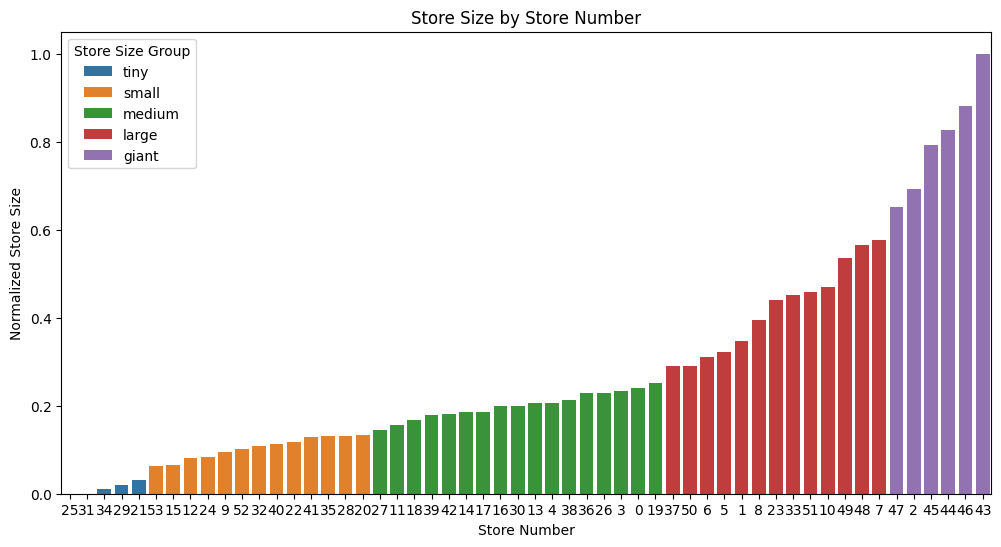

In [ ]:
from sklearn.preprocessing import MinMaxScaler

def extract_store_size(transactions):
  # Calculate the average number of transactions per store
  transactions = transactions.groupby('store_nbr')[
      'transactions'].mean().reset_index()
  # Create numerical store_size feature based on scaled transaction means
  transactions['store_size'] = MinMaxScaler().fit_transform(
      transactions.transactions.values.reshape(-1, 1))
  # Define thresholds for categorizing stores into different sizes
  thresholds = {
      'tiny': transactions['transactions'].quantile(0.09),
      'small': transactions['transactions'].quantile(0.33),
      'medium': transactions['transactions'].quantile(0.66),
      'large': transactions['transactions'].quantile(0.9),
  }

  # Create a new ordinal categorical feature 'store_size' based on the thresholds
  def categorize_store_size(avg_transactions):
      if avg_transactions <= thresholds['tiny']:
          return 'tiny'
      elif avg_transactions <= thresholds['small']:
          return 'small'
      elif avg_transactions <= thresholds['medium']:
          return 'medium'
      elif avg_transactions <= thresholds['large']:
          return 'large'
      else:
          return 'giant'

  transactions['store_size_group'] = transactions[
      'transactions'].apply(categorize_store_size)
  transactions['store_size_group'] = pd.Categorical(
      transactions['store_size_group'], categories=[
          'tiny', 'small', 'medium', 'large', 'giant'], ordered=True)
  transactions.drop(columns='transactions', inplace=True)
  return transactions

def show_store_size(df):
  df = extract_store_size(df)
  # Plotting
  plt.figure(figsize=(12, 6))
  order = df.sort_values('store_size').store_nbr
  sns.barplot(x='store_nbr', y='store_size', hue='store_size_group',
              data=df, dodge=False, order=order)
  plt.title('Store Size by Store Number')
  plt.xlabel('Store Number')
  plt.ylabel('Normalized Store Size')
  plt.legend(title='Store Size Group')
  plt.show()

show_store_size(df_trans)

### Extract City and State Size from Census Data

In [ ]:
from io import StringIO

def extract_census_date():
  census_city = StringIO("""
city,population_city
Amaguaña,10628
Ambato,177316
Anconcito,15033
Arenillas,21524
Atacames,18948
Atuntaqui (Antonio Ante),25115
Azogues,35763
Babahoyo,98251
Bahía de Caráquez (Sucre),22209
Balao,12850
Balzar,32744
Baños de Agua Santa,14100
Buena Fé (San Jacinto de Buena Fé),46779
Calceta (Bolivar),20011
Calderón,249941
Camilo Ponce Enríquez,10015
Cañar,13148
Cariamanga,13175
Catamayo,27026
Cayambe,44559
Charapotó,11879
Chaupitena (incl. Tena and Santa Isabel),16066
Chone,54629
Conocoto,121984
Cotacachi,10526
Crucita,10318
Cuenca,361524
Cumandá,11442
Cumbayá,41740
Daule,46438
Durán (Eloy Alfaro),295211
El Carmen,52366
El Guabo,26635
El Salitre,13571
El Triunfo,41042
Esmeraldas,155487
Gualaceo (Santiago de Gualaceo),13843
Guaranda,30755
Guayaquil,2650288
Guayllabamba,13336
Huachi Grande,11335
Huaquillas,56021
Ibarra,157941
Izamba,13365
Jaramijó,28397
Jipijapa,45382
José Luis Tamayo (Muey),35833
La Aurora (incl. San Antonio),116593
La Concordia,35474
La Joya de los Sachas,16023
Libertad,112154
La Maná,31740
La Puntilla,55357
Latacunga,77267
La Troncal,39600
La Unión,10480
Llano Chico,14741
Loja,203496
Lomas de Sargentillo,16603
Macará,12454
Macas (Morona),22398
Machachi,24188
Machala,288072
Manta,258697
Milagro,159970
Montalvo,16248
Montecristi,71066
Naranjal,39323
Naranjito,34664
Nobol,10010
Nueva Loja (Lago Agrio),55627
Otavalo,41718
Palestina,10392
Pasaje,60147
Pedernales,27068
Pedro Carbo,24882
Pelileo,11403
Pifo,12868
Píllaro,9816
Piñas,18482
Playas,48156
Pomasqui,28724
Portoviejo,244129
Posorja,30886
Puerto Ayora,12696
Puerto Baquerizo Moreno (San Cristóbal),7290
Puerto Francisco de Orellana (Ciudad Coco),51281
Puerto López,12598
Pujilí,16152
Puyo,33325
Quevedo,177792
Quito,1763275
Ricaurte,13378
Riobamba,177213
Rocafuerte,11848
Rosa Zárate (Quinindé),31120
Salcedo (San Miguel),16751
Salinas,35066
Samborondón,17068
San Antonio de Ibarra,13626
San Antonio de Pichincha,45380
San Carlos,22529
San Gabriel (Montúfar),14497
Sangolquí (Rumiñahui),96647
San Juan,12819
San Lorenzo,28491
Santa Ana de Vuelta Larga,11918
Santa Elena,54565
Santa Lucía,10924
Santa Rosa,56842
Santo Domingo,334826
Santo Domingo de Cutuglahua (Cutuglahua),15356
San Vicente,10404
Saquisilí,9883
Shushufindi,16328
Sucúa,10846
Tabacundo,13019
Tarifa,10584
Tena,29724
Tonsupa,11526
Tosagua,11317
Tulcán,56719
Tumbaco,70789
Valencia,22996
Velasco Ibarra (El Empalme),41778
Ventanas,41531
Vinces,35064
Virgen de Fátima,15066
Yaguachi (San Jacinto de Yaguachi),22972
Yantzaza,13335
Yaruquí,11276
Zamora,17584
Zaruma,10005
""")
  census_state = StringIO("""
state,population_state
Azuay,801609
Bolivar,199078
Cañar,227578
Carchi,172828
Chimborazo,471933
Cotopaxi,470210
El Oro,714592
Esmeraldas,553900
Galápagos,28583
Guayas,4391923
Imbabura,469879
Loja,485421
Los Rios,898652
Manabi,1592840
Morona Santiago,192508
Napo,131675
Orellana,182166
Pastaza,111915
Pichincha,3089473
Santa Elena,385735
Santo Domingo de los Tsachilas,492969
Sucumbíos,199014
Tungurahua,563532
Zamora Chinchipe,110973
""")
  city = pd.read_table(census_city, sep=',', dtype=dict(city='category', population_city=int))
  state = pd.read_table(census_state, sep=',', dtype=dict(state='category', population_state=int))
  return city, state

### Extract whether a store was open based on sum over sales

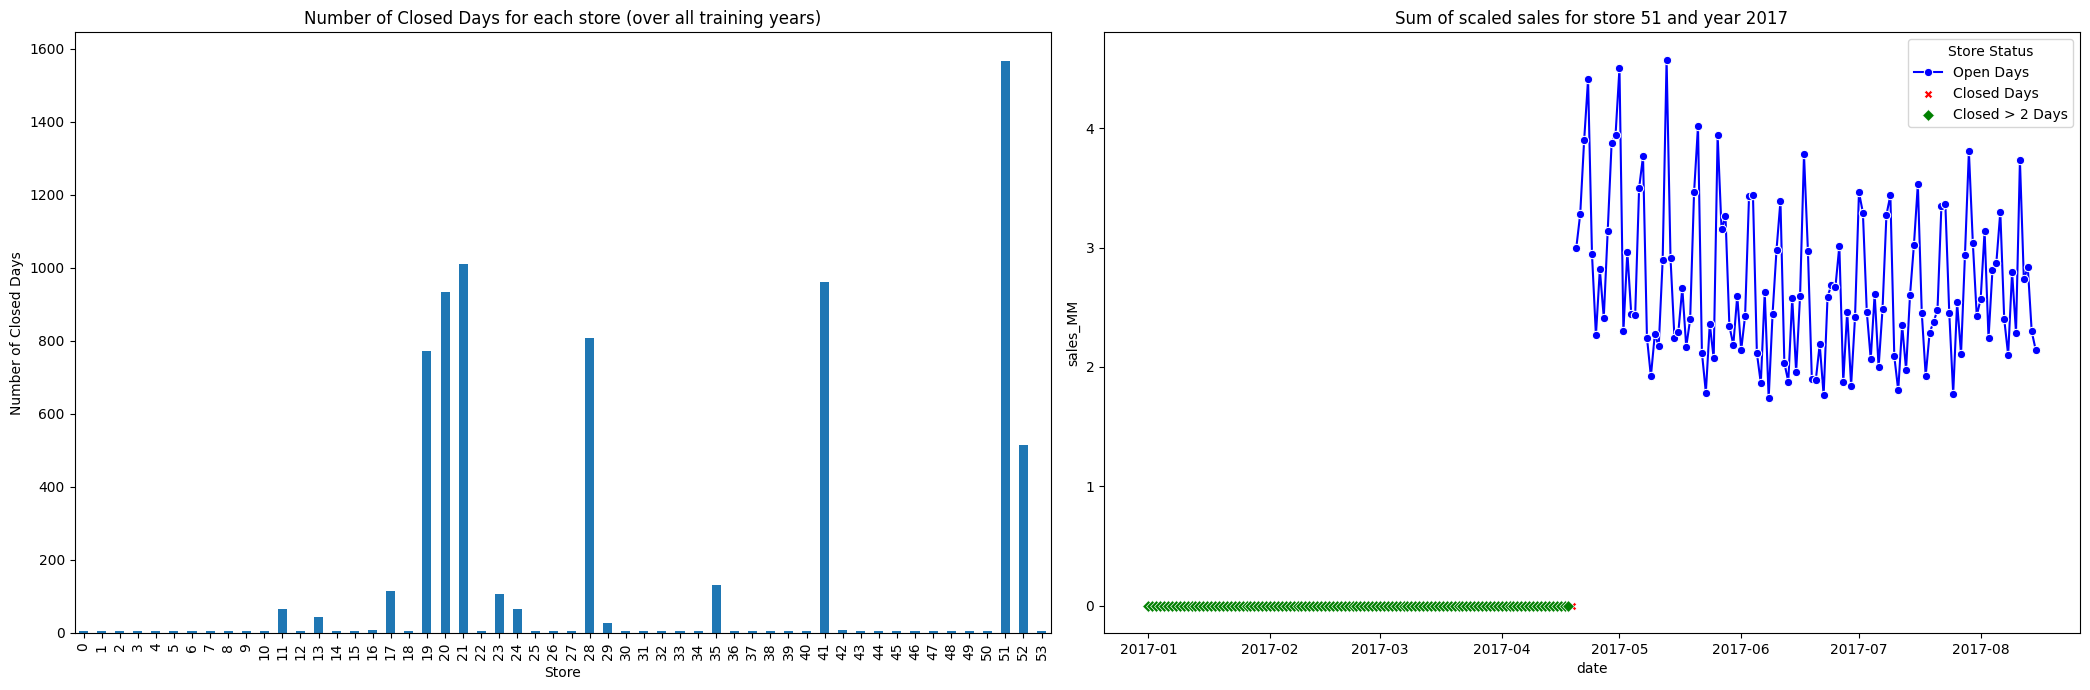

In [ ]:
def extract_closed_n_days_in_group(group, n_days):
  is_closed = ~ group.is_open
  num_days_closed = is_closed.astype(int).rolling(
      window=n_days, min_periods=1, center=True
  ).sum()
  group['is_closed_n_days'] = num_days_closed == n_days
  return group

def extract_is_open(df):
  df = sort_df(df)
  df['is_open'] = df['sales_MM'] > 0
  return df

def extract_open_closed_n_days(df, n_days=3):
  # Detect whether the store was closed for more than n days in a row
  df = df.groupby('store_nbr').apply(
      extract_closed_n_days_in_group, n_days=n_days).reset_index(drop=True)
  return sort_df(df)

def show_closed_stores(df, store=18, year=2016):
  df = extract_is_open(df)
  df = extract_open_closed_n_days(df)
  fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(21, 7))
  df[~df.is_open].groupby('store_nbr')['date'].count().plot.bar(
      xlabel='Store', ylabel='Number of Closed Days',
      title='Number of Closed Days for each store (over all training years)',
      ax=ax1
  )
  filter = (df.store_nbr == store) & (df['date'].dt.year == year)
  df_store_year = df[filter]
  sns.lineplot(
      x='date', y='sales_MM', data=df_store_year[df_store_year.is_open],
      marker='o', ax=ax2, color='blue', label='Open Days'
  )
  sns.scatterplot(
      x='date', y='sales_MM', data=df_store_year[
          ~df_store_year.is_open & ~df_store_year.is_closed_n_days],
      color='red', marker='X', ax=ax2, label='Closed Days'
  )
  sns.scatterplot(
      x='date', y='sales_MM', data=df_store_year[df_store_year.is_closed_n_days],
      color='green', marker='D', ax=ax2, label=f'Closed > 2 Days'
  )
  ax2.set_title(f'Sum of scaled sales for store {store} and year {year}')
  ax2.legend(title='Store Status', loc='best')
  plt.tight_layout()
  plt.show()

show_closed_stores(df_train, store=51, year=2017)

### Z-Scores for Outlier Detection


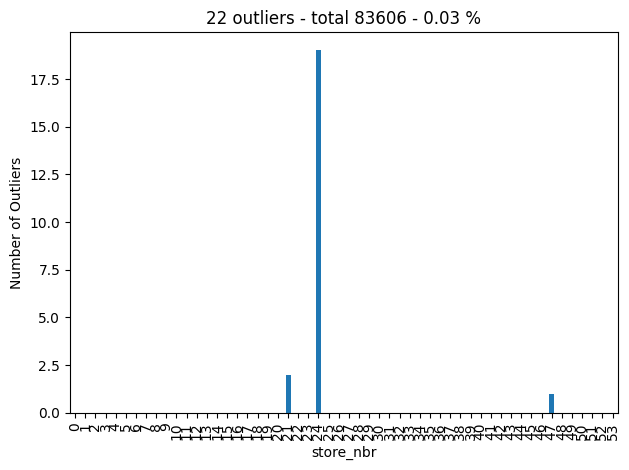

In [ ]:
def identify_outliers_in_group(group, target_columns, num_col_outliers,
                               exclude_closed_days):
    threshold = 3
    is_outlier_columns = [f'{col}_is_outlier' for col in target_columns]
    for col, is_outlier_col in zip(target_columns, is_outlier_columns):
      target = group[col]
      if exclude_closed_days:
        target = group[group.is_open][col]
      else:
        target = group[col]
      target_std = target.std()
      if target_std == 0.0:
        group[is_outlier_col] = True
      else:
        z_score = (group[col] - target.mean()) / target_std
        group[is_outlier_col] = z_score.abs() > threshold
    # Mark as outliers if Z-score is above the threshold for more than num_col_outliers
    group['is_outlier'] = group[is_outlier_columns].sum(axis=1) > num_col_outliers
    return group

def outlier_detection(df, target_columns=sales_columns, num_col_outliers=round(
    len(sales_columns) / 2), exclude_closed_days=True):
  df = df.groupby(['store_nbr']).apply(
    identify_outliers_in_group, target_columns=target_columns,
    num_col_outliers=num_col_outliers, exclude_closed_days=exclude_closed_days).reset_index(drop=True)
  return sort_df(df)

def plot_outliers(df):
  df = extract_is_open(df)
  df = outlier_detection(df[df.is_open])
  num_out = sum(df.is_outlier)
  num_total = df.shape[0]
  df[df.is_outlier].groupby(['store_nbr'])['date'].count().plot.bar()
  plt.title(f'{num_out} outliers - total {num_total} - {(100 * num_out / num_total):.2f} %')
  plt.ylabel('Number of Outliers')
  plt.tight_layout()
  plt.show()

plot_outliers(df_train)

## Source Data Merging

In [ ]:
class SalesDataExtractor:
  def __init__(self,
               df_oil=df_oil,
               df_holy=df_holy,
               df_store=df_store,
               df_trans=df_trans):
    self.df_date_oil = extract_filled_oil_prices(create_date_features(),
                                                 df_oil)
    self.df_store = self.merge_store_data(df_store, df_trans)
    self.df_holy = extract_holidays(df_holy, df_store)

  @staticmethod
  def merge_store_data(store, transactions):
    transactions = extract_store_size(transactions)
    store = store.merge(transactions, on='store_nbr', how='left', validate='1:1')
    city, state = extract_census_date()
    store = store.merge(city, on='city', how='left', validate='m:1')
    store = store.merge(state, on='state', how='left', validate='m:1')
    return store

  def merge_source_data(self, df):
    df = df.merge(self.df_holy, on=['date', 'store_nbr'], how='left', validate='1:1')
    df[['is_holiday', 'is_event', 'is_free']] = df[
        ['is_holiday', 'is_event', 'is_free']].fillna(False)
    df = df.merge(self.df_date_oil, on='date', how='left', validate='m:1')
    df.is_free = df.is_free & df.is_weekend
    df = df.drop(columns='is_weekend')
    df = df.merge(self.df_store, on='store_nbr', how='left', validate='m:1')
    for feat in ['city', 'state', 'store_nbr']: # dtype object after merging
      df[feat] = pd.Categorical(df[feat])
    return sort_df(df)

SalesDataExtractor().merge_source_data(df_train).duplicated(
    subset=['date', 'store_nbr']).sum()

0

# Mutual Information and Correlation

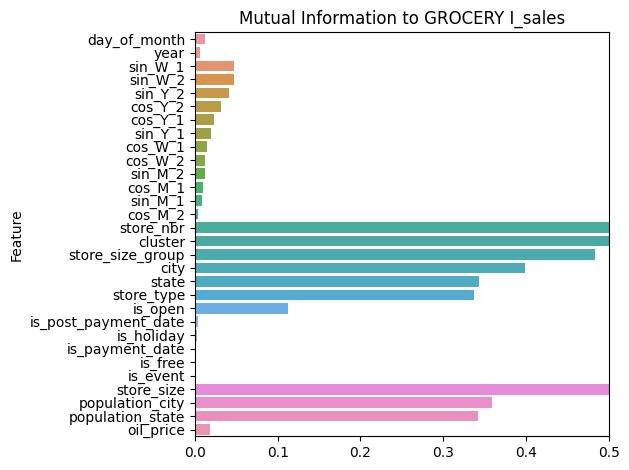

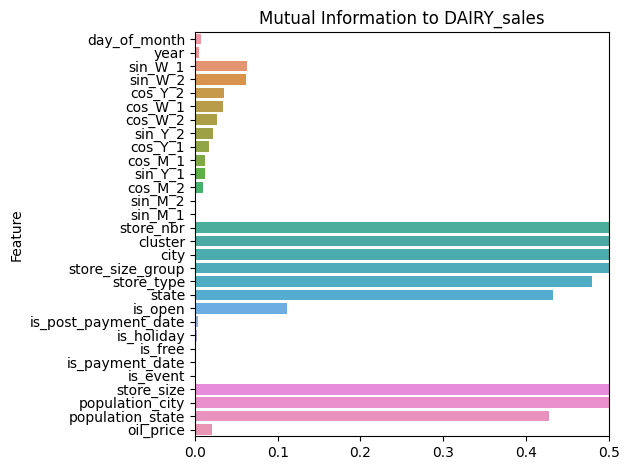

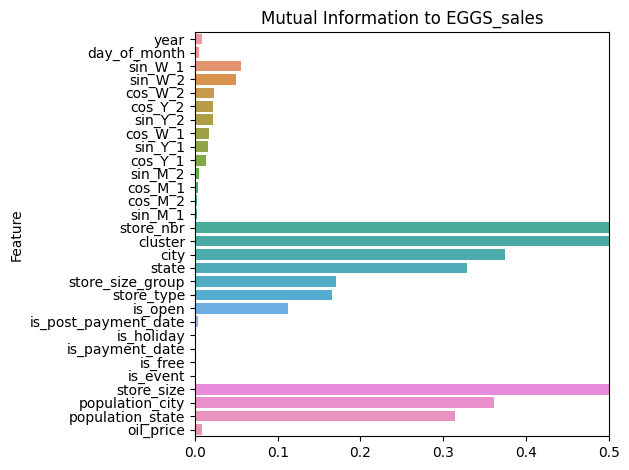

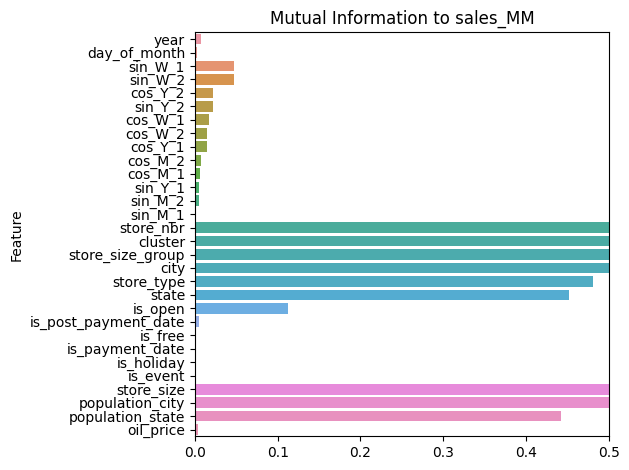

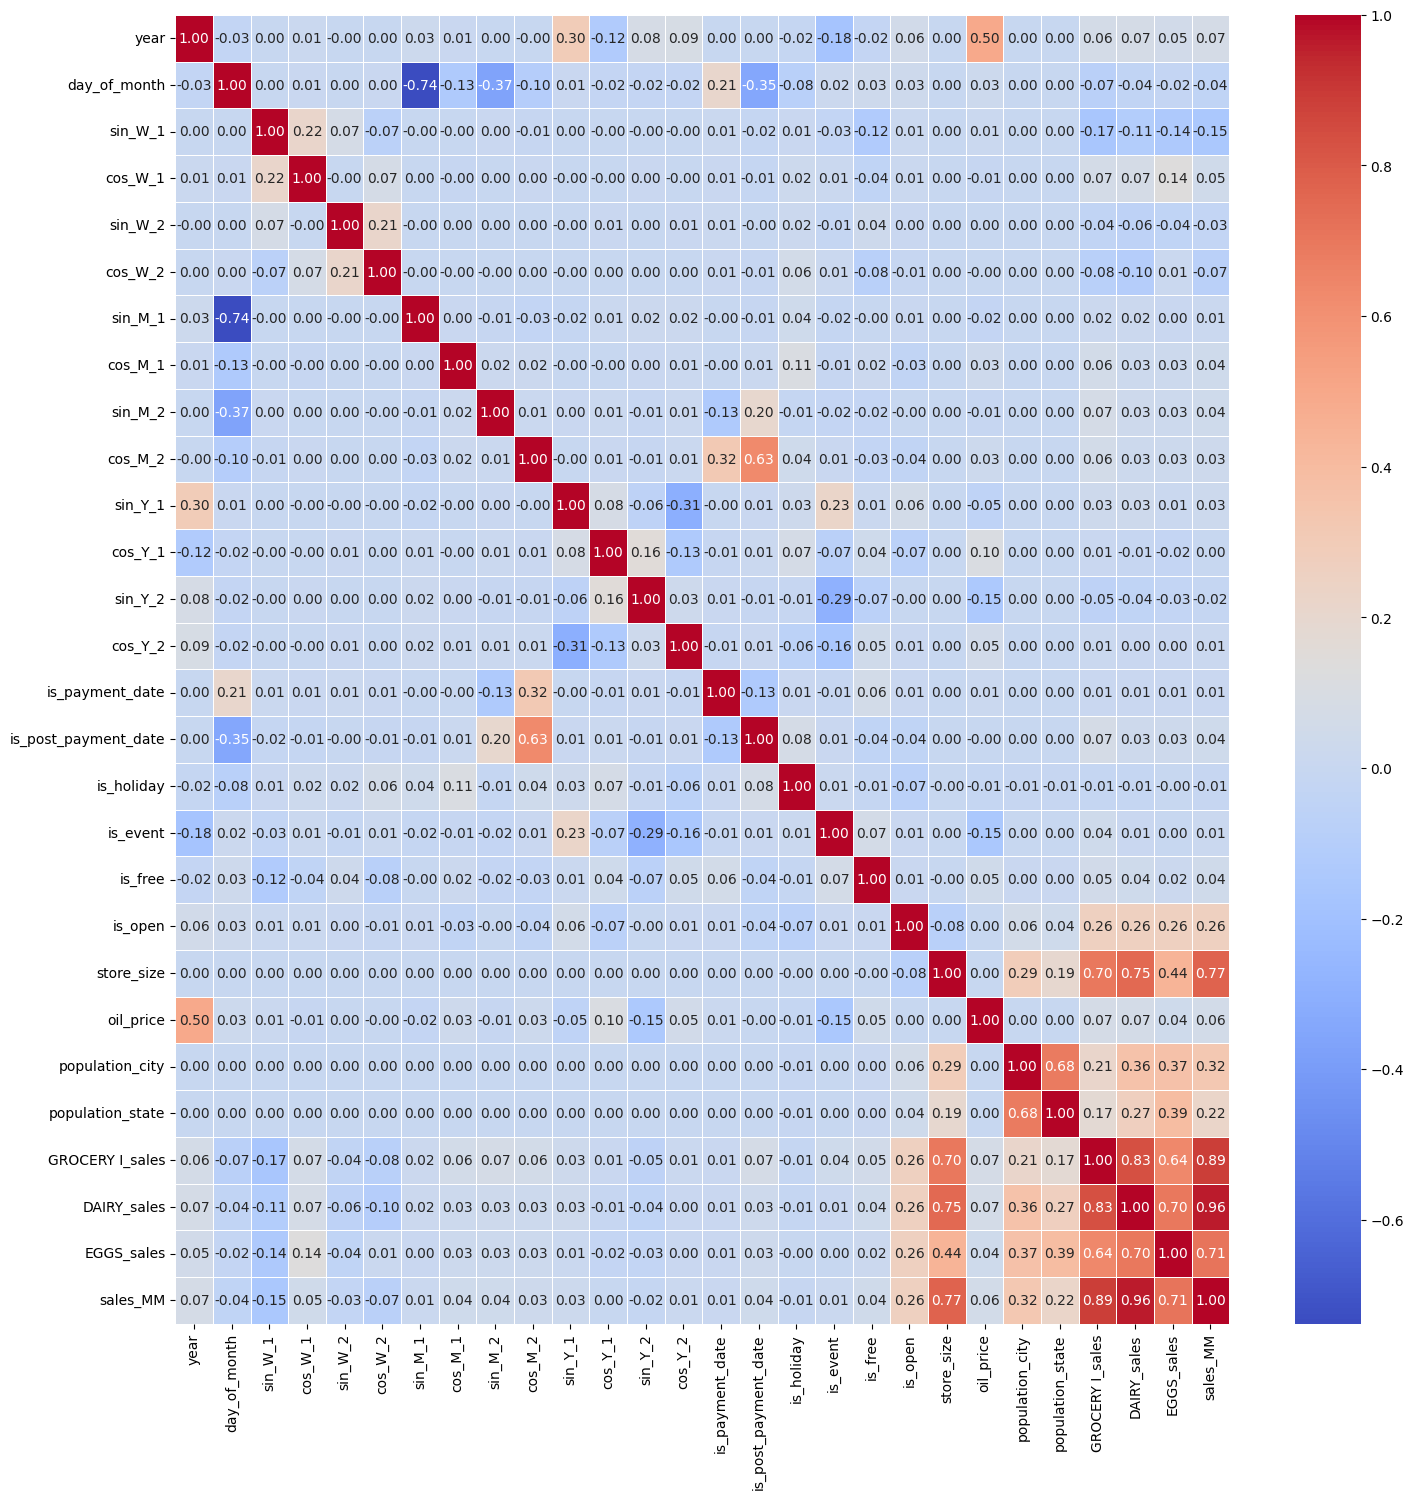

In [ ]:
from sklearn.feature_selection import mutual_info_regression

def sorted_mutual_info(df, feature_lists, is_discrete_list, col_target):
  y = df[col_target]
  mi = []
  for features, is_discrete in zip(feature_lists, is_discrete_list):
    mutual_info_score = mutual_info_regression(df[features], y,
                    discrete_features=is_discrete, random_state=SEED)
    mutual_info = pd.Series({
      feat: score for feat, score in zip(features, mutual_info_score)
    }).sort_values(ascending=False)
    mi.append(mutual_info)
  return pd.concat(mi)

def show_mutual_info_correlation(df, feat_date, feat_emb,
                                 feat_bool, feat_numeric, families=['DAIRY_sales']):
  _, df = split_by_date(df, month=1, year=2016)
  df = extract_is_open(df)
  df = SalesDataExtractor().merge_source_data(df)
  feat_fourier = [col for col in list(df.columns) if col.startswith('sin') or col.startswith('cos')]
  for family in families:
    mutual_info = sorted_mutual_info(df,
                      feature_lists = [feat_date, feat_fourier, feat_emb, feat_bool, feat_numeric],
                      is_discrete_list = [True, False, True, True, False],
                      col_target=family)
    sns.barplot(x=mutual_info, y=mutual_info.index)
    plt.xlim((0.0, 0.5))
    plt.title(f'Mutual Information to {family}')
    plt.xlabel('')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

  features = feat_date + feat_fourier + feat_bool + feat_numeric # exclude feat_emb (spearman needs ranking)
  corr = df[features + families].corr(method='spearman')
  fig, ax = plt.subplots(figsize=(17,17))
  sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm',
              linewidths=0.5, ax=ax)

show_mutual_info_correlation(
    df_train,
    feat_date=['year', 'day_of_month'],
    feat_emb=['store_nbr', 'store_type', 'cluster', 'city', 'state', 'store_size_group'],
    feat_bool=['is_payment_date', 'is_post_payment_date',
                'is_holiday', 'is_event', 'is_free', 'is_open'],
    feat_numeric=['store_size', 'oil_price', 'population_city', 'population_state'],
    families=['GROCERY I_sales', 'DAIRY_sales', 'EGGS_sales', 'sales_MM']
)

## Feature Selection


# Feature Scaling and Encoding Pipeline




In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder, OneHotEncoder

class DataPipeline:
  def __init__(self,
      feat_minmax: list[str],
      feat_onehot: list[str],
      feat_ordinal: list[str],
      feat_std: list[str],
      feat_storewise: list[str],
      filter_closed_outlier: bool,
      feat_pass: list[str],
      target_columns=sales_columns,
      id_columns=id_columns,
      **storewise_kwargs
  ):
    self.target_columns = target_columns
    self.id_columns = id_columns
    self.filter_train = filter_closed_outlier
    if feat_storewise:
      self.storewise_feat_transformer = StorewiseTransformer(feat_storewise,
        **storewise_kwargs)
      self.feat_lag = self.storewise_feat_transformer.feat_lag
    else:
      self.storewise_feat_transformer = None
      self.feat_lag = []
    self.target_transformer = StorewiseTransformer(target_columns,
        **storewise_kwargs)
    self.feat_lag = self.feat_lag + self.target_transformer.feat_lag
    self.data_extractor = SalesDataExtractor()
    self.feat_pass = feat_pass + feat_storewise + self.feat_lag
    self.feat_transformer = ColumnTransformer(
      transformers=[
          ('minmax', MinMaxScaler(), feat_minmax), # float
          ('ordinal', OrdinalEncoder(dtype=int), feat_ordinal), # int
          ('onehot', OneHotEncoder(drop=None, sparse_output=False), feat_onehot),
          ('std', StandardScaler(), feat_std), # float
      ], sparse_threshold=0.0, verbose_feature_names_out=False, remainder='drop')
    self.feat_transformer.set_output(transform='pandas')

  def fit_transform(self, df):
    df = sort_df(df)
    df = extract_is_open(df)
    if self.filter_train:
      df = outlier_detection(df)
    if self.storewise_feat_transformer is not None:
      df = self.storewise_feat_transformer.fit_transform(df)
    df = self.target_transformer.fit_transform(df)
    # now we can savely drop NaNs that resulted from shift
    df = self.target_transformer.remove_first_lag_diff(df)
    df = self.data_extractor.merge_source_data(df)
    if self.filter_train:
      df = df[(df.is_open & ~df.is_outlier) | df.is_used_for_diff_lag]
    df_preprocessed = self.feat_transformer.fit_transform(df)
    return pd.concat((df_preprocessed, df[
        self.feat_pass + self.target_columns]), axis=1)

  def transform(self, df, include_sales: bool):
    df = sort_df(df)
    if self.storewise_feat_transformer is not None:
      df = self.storewise_feat_transformer.transform_unseen(df)
    if include_sales:
      df = self.target_transformer.transform_unseen(df)
    elif self.feat_lag:
      df = self.target_transformer.transform_lag_unseen(df)
    df = self.data_extractor.merge_source_data(df)
    df_preprocessed = self.feat_transformer.transform(df)
    if not self.filter_train: # add dummies
      df_preprocessed['is_open'] = 1
      df_preprocessed['is_outlier'] = 0
    cols_to_pass = self.target_columns if include_sales else self.id_columns
    return pd.concat((df_preprocessed, df[
        self.feat_pass + cols_to_pass]), axis=1)

  def inverse_transform_target(self, df, unseen: bool):
    return self.target_transformer.inverse_transform(df, unseen=unseen)

pipe = DataPipeline(
  feat_minmax=['year', 'is_post_payment_date', 'is_holiday', 'is_free'],
  feat_onehot=['store_type'],
  feat_ordinal=['cluster', 'city', 'state'],
  feat_std=['store_size', 'oil_price', 'population_city', 'population_state'],
  feat_pass=fourier_columns+['date', 'store_nbr'],
  feat_storewise=onpromotion_columns,
  filter_closed_outlier=True,
  apply_power=False,
  apply_scaling=True,
  diff_period=0,
  lag_period=0
)
print(f'Lagged Features: {pipe.feat_lag}')
print('NaN values after transforming training data: ',
      pipe.fit_transform(df_train).isna().sum().sum())
pipe.transform(df_test, include_sales=False).isna().sum().sum()

Lagged Features: []
NaN values after transforming training data:  0


0

# Analysis

In [ ]:
# for the sake of compute resources we only analyse 2016 and 2017
# and show a subset of stores and product families
_, df_ana = split_by_date(df_train, year=2016, month=1) # 592 days
ana_families=['DAIRY_sales', 'EGGS_sales', 'GROCERY I_sales', 'GROCERY II_sales']
ana_stores=[25, 32, 4, 51, 7, 43] # follows store size ordering (51 started in 04 17)
df_ana = SalesDataExtractor().merge_source_data(df_ana)
df_ana = extract_is_open(df_ana)
df_ana[df_ana.store_nbr.isin(ana_stores)][['date', 'store_nbr'] + ana_families].tail()

date store_nbr  DAIRY_sales  EGGS_sales  GROCERY I_sales  \
31921 2017-08-15         7       1330.0       298.0           4035.0   
31939 2017-08-15        25        263.0        36.0           1100.0   
31946 2017-08-15        32        488.0       163.0           3240.0   
31957 2017-08-15        43       1918.0       506.0           8123.0   
31965 2017-08-15        51       1053.0       177.0           5141.0   

       GROCERY II_sales  
31921              27.0  
31939               3.0  
31946               2.0  
31957              84.0  
31965              30.0

## Autoregression: PACF and Differencing (ADF-Test)

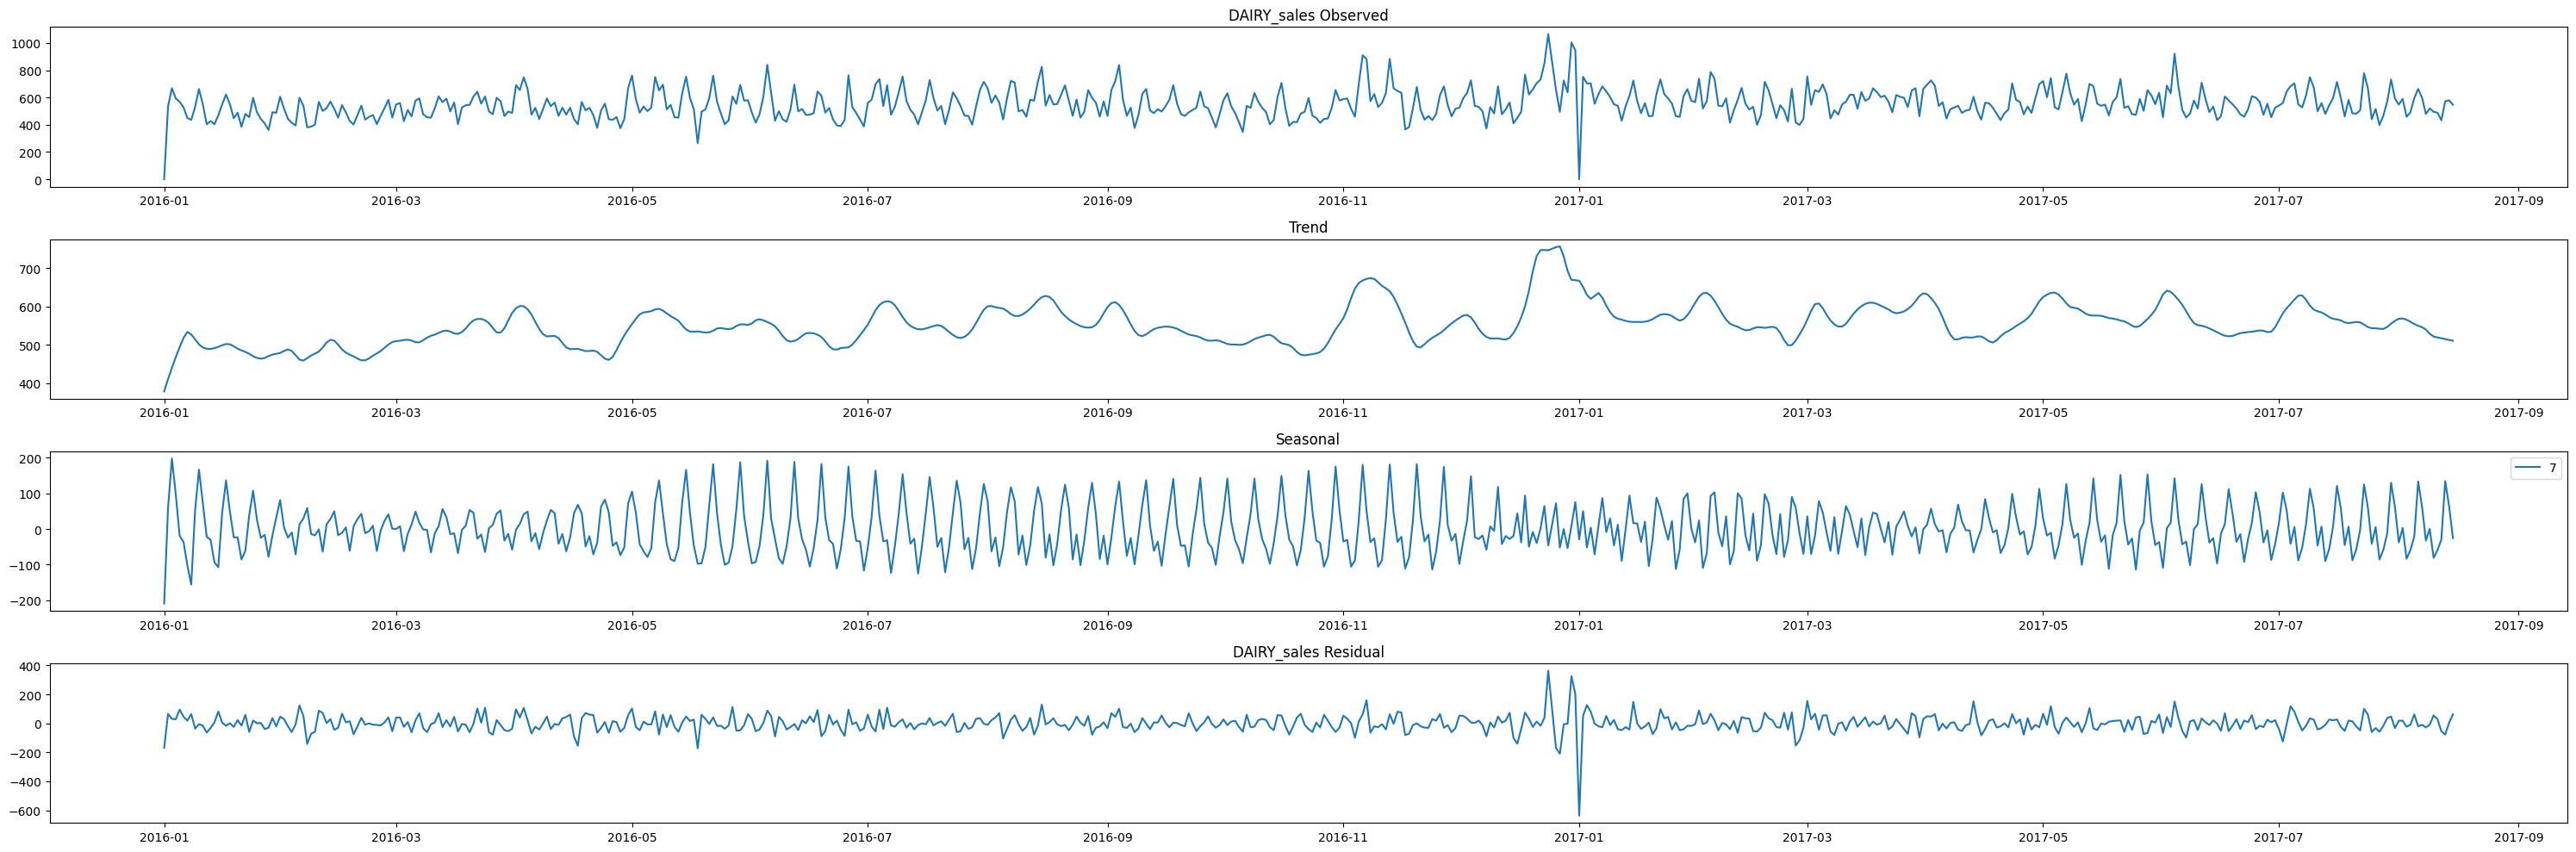

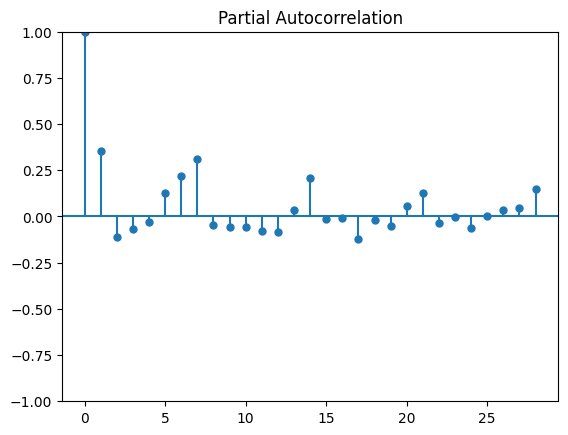

Needs Differencing  Diff p-value
AUTOMOTIVE_sales                               False      0.010000
BABY CARE_sales                                False      0.010000
BEAUTY_sales                                   False      0.010000
BEVERAGES_sales                                False      0.010000
BOOKS_sales                                     True      0.153397
BREAD/BAKERY_sales                             False      0.010000
CELEBRATION_sales                              False      0.010000
CLEANING_sales                                 False      0.010000
DAIRY_sales                                    False      0.010000
DELI_sales                                     False      0.010000
EGGS_sales                                     False      0.010000
FROZEN FOODS_sales                             False      0.010000
GROCERY I_sales                                False      0.010000
GROCERY II_sales                               False      0.012448
HARDWARE_sales                                 False      0.010000
HOME AND KITCHEN I_sales                       False      0.010000
HOME AND KITCHEN II_sales                      False      0.010000
HOME APPLIANCES_sales                          False      0.010000
HOME CARE_sales                                False      0.010000
LADIESWEAR_sales                               False      0.010000
LAWN AND GARDEN_sales                          False      0.010000
LINGERIE_sales                                 False      0.010000
LIQUOR,WINE,BEER_sales                         False      0.010000
MAGAZINES_sales                                False      0.010000
MEATS_sales                                    False      0.010000
PERSONAL CARE_sales                            False      0.010000
PET SUPPLIES_sales                             False      0.010000
PLAYERS AND ELECTRONICS_sales                  False      0.010000
POULTRY_sales                                  False      0.010000
PREPARED FOODS_sales                           False      0.010000
PRODUCE_sales                                  False      0.010000
SCHOOL AND OFFICE SUPPLIES_sales               False      0.010000
SEAFOOD_sales                                  False      0.010000

In [ ]:
from statsmodels.tsa.seasonal import STL, MSTL
from pmdarima.arima import ADFTest
from pmdarima.utils import plot_pacf

def get_stl_decomposition(df, columns, periods):
  df = df[['date', 'store_nbr'] + columns].copy()
  for col in columns:
    stl = MSTL(df[col], periods=periods)
    result = stl.fit()
    df[f'{col}_trend'] = result.trend
    if isinstance(periods, int):
      df[f'{col}_seasonal_{periods}'] = result.seasonal
    else:
      for i, p in enumerate(periods):
        df[f'{col}_seasonal_{p}'] = result.seasonal.values[:, i]
    df[f'{col}_resid'] = result.resid
  return df

def plot_decomposition(df, family_to_plot, periods=(7, 30)):
  result = get_stl_decomposition(df, columns=[family_to_plot], periods=periods)
  plt.figure(figsize=(30,10))
  plt.subplot(411)
  plt.plot(result['date'], result[f'{family_to_plot}'])
  plt.title(f'{family_to_plot} Observed')
  plt.subplot(412)
  plt.plot(result['date'], result[f'{family_to_plot}_trend'])
  plt.title('Trend')
  plt.subplot(413)
  if isinstance(periods, int):
    periods = [periods]
  for p in periods:
    plt.plot(result['date'], result[f'{family_to_plot}_seasonal_{p}'], label=p)
  plt.legend()
  plt.title('Seasonal')
  plt.subplot(414)
  plt.plot(result['date'], result[f'{family_to_plot}_resid'])
  plt.title(f'{family_to_plot} Residual')
  plt.tight_layout()
  plt.show()

def augmented_dickey_fuller_test(df, columns):
  should_diff, should_diff_p = [], []
  adf = ADFTest()
  for col in columns:
    x = df[col]
    pval, sig = adf.should_diff(x)
    should_diff.append(sig)
    should_diff_p.append(pval)
  return pd.DataFrame(index=columns, data={
    'Needs Differencing': should_diff, 'Diff p-value': should_diff_p,
  })

def show_decomposition_pacf_adf(df, family=ana_families[0],
                                store_nbr=ana_stores[2], period=7):
  df = df[(df.store_nbr == store_nbr)]
  plot_decomposition(df, family_to_plot=family, periods=period)
  plot_pacf(df[family])
  return augmented_dickey_fuller_test(df, sales_columns)

show_decomposition_pacf_adf(df_ana)

## Average Sales per Feature

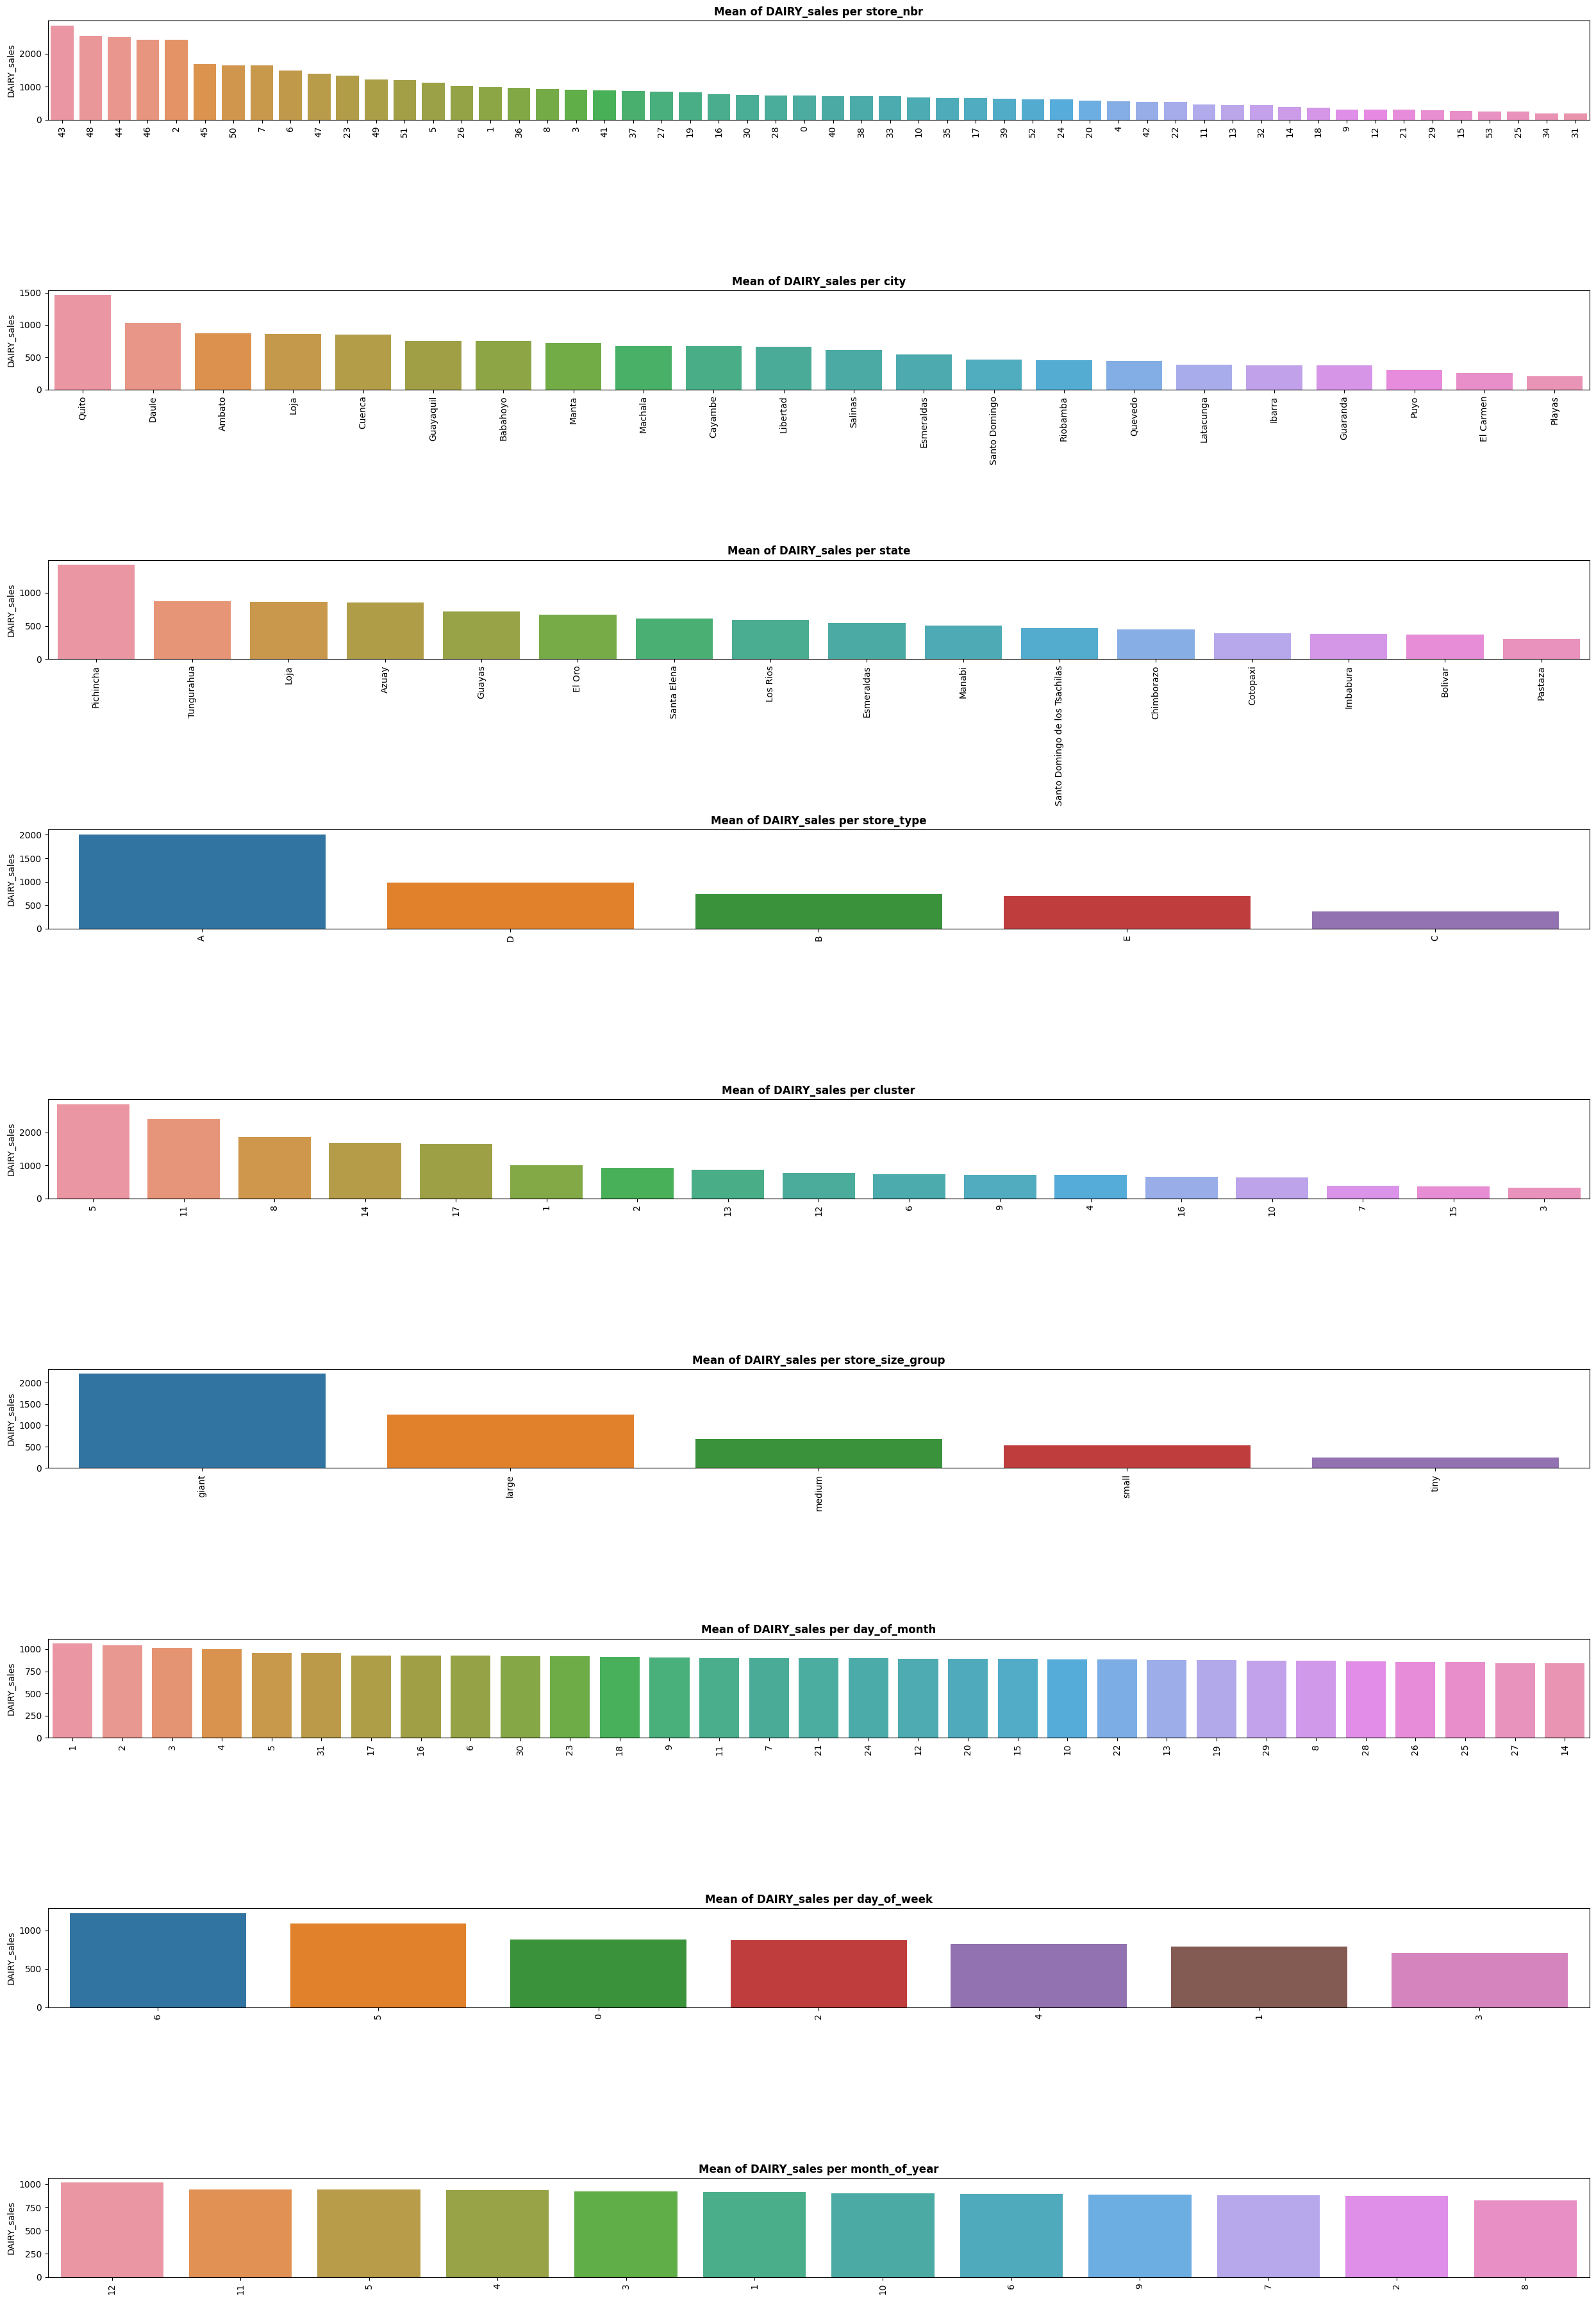

In [ ]:
feat_date = ['day_of_month', 'day_of_week', 'month_of_year']
features = ['store_nbr', 'city', 'state', 'store_type', 'cluster', 'store_size_group'] + feat_date

def beauty_ax(ax_i, title):
  ax_i.set_title(title, fontweight="bold")
  ax_i.set_xlabel('')
  for tick in ax_i.get_xticklabels():
    tick.set_rotation(90)

def show_sales_per_feature(df, features, target='sales_MM'):
  df = df[df.is_open]
  fig, ax = plt.subplots(nrows=len(features),
                         ncols=1, figsize=(25, len(features) * 4))
  for i, feat in enumerate(features):
    # Calculate the average sales per year for each feature
    ax_i = ax[i]
    ordering = df.groupby(feat, as_index=True)[
        target].mean().sort_values(ascending=False).index
    df_avg_per_year = df.groupby(
        [feat], as_index=False)[target].mean()
    sns.barplot(data=df_avg_per_year, x=feat, y=target,
                order=ordering, ax=ax_i)
    beauty_ax(ax_i, f'Mean of {target} per {feat}')
  plt.tight_layout()
  plt.show()

show_sales_per_feature(df_ana, features, target=ana_families[0])

## Daily Sales vs Oil Price per product category

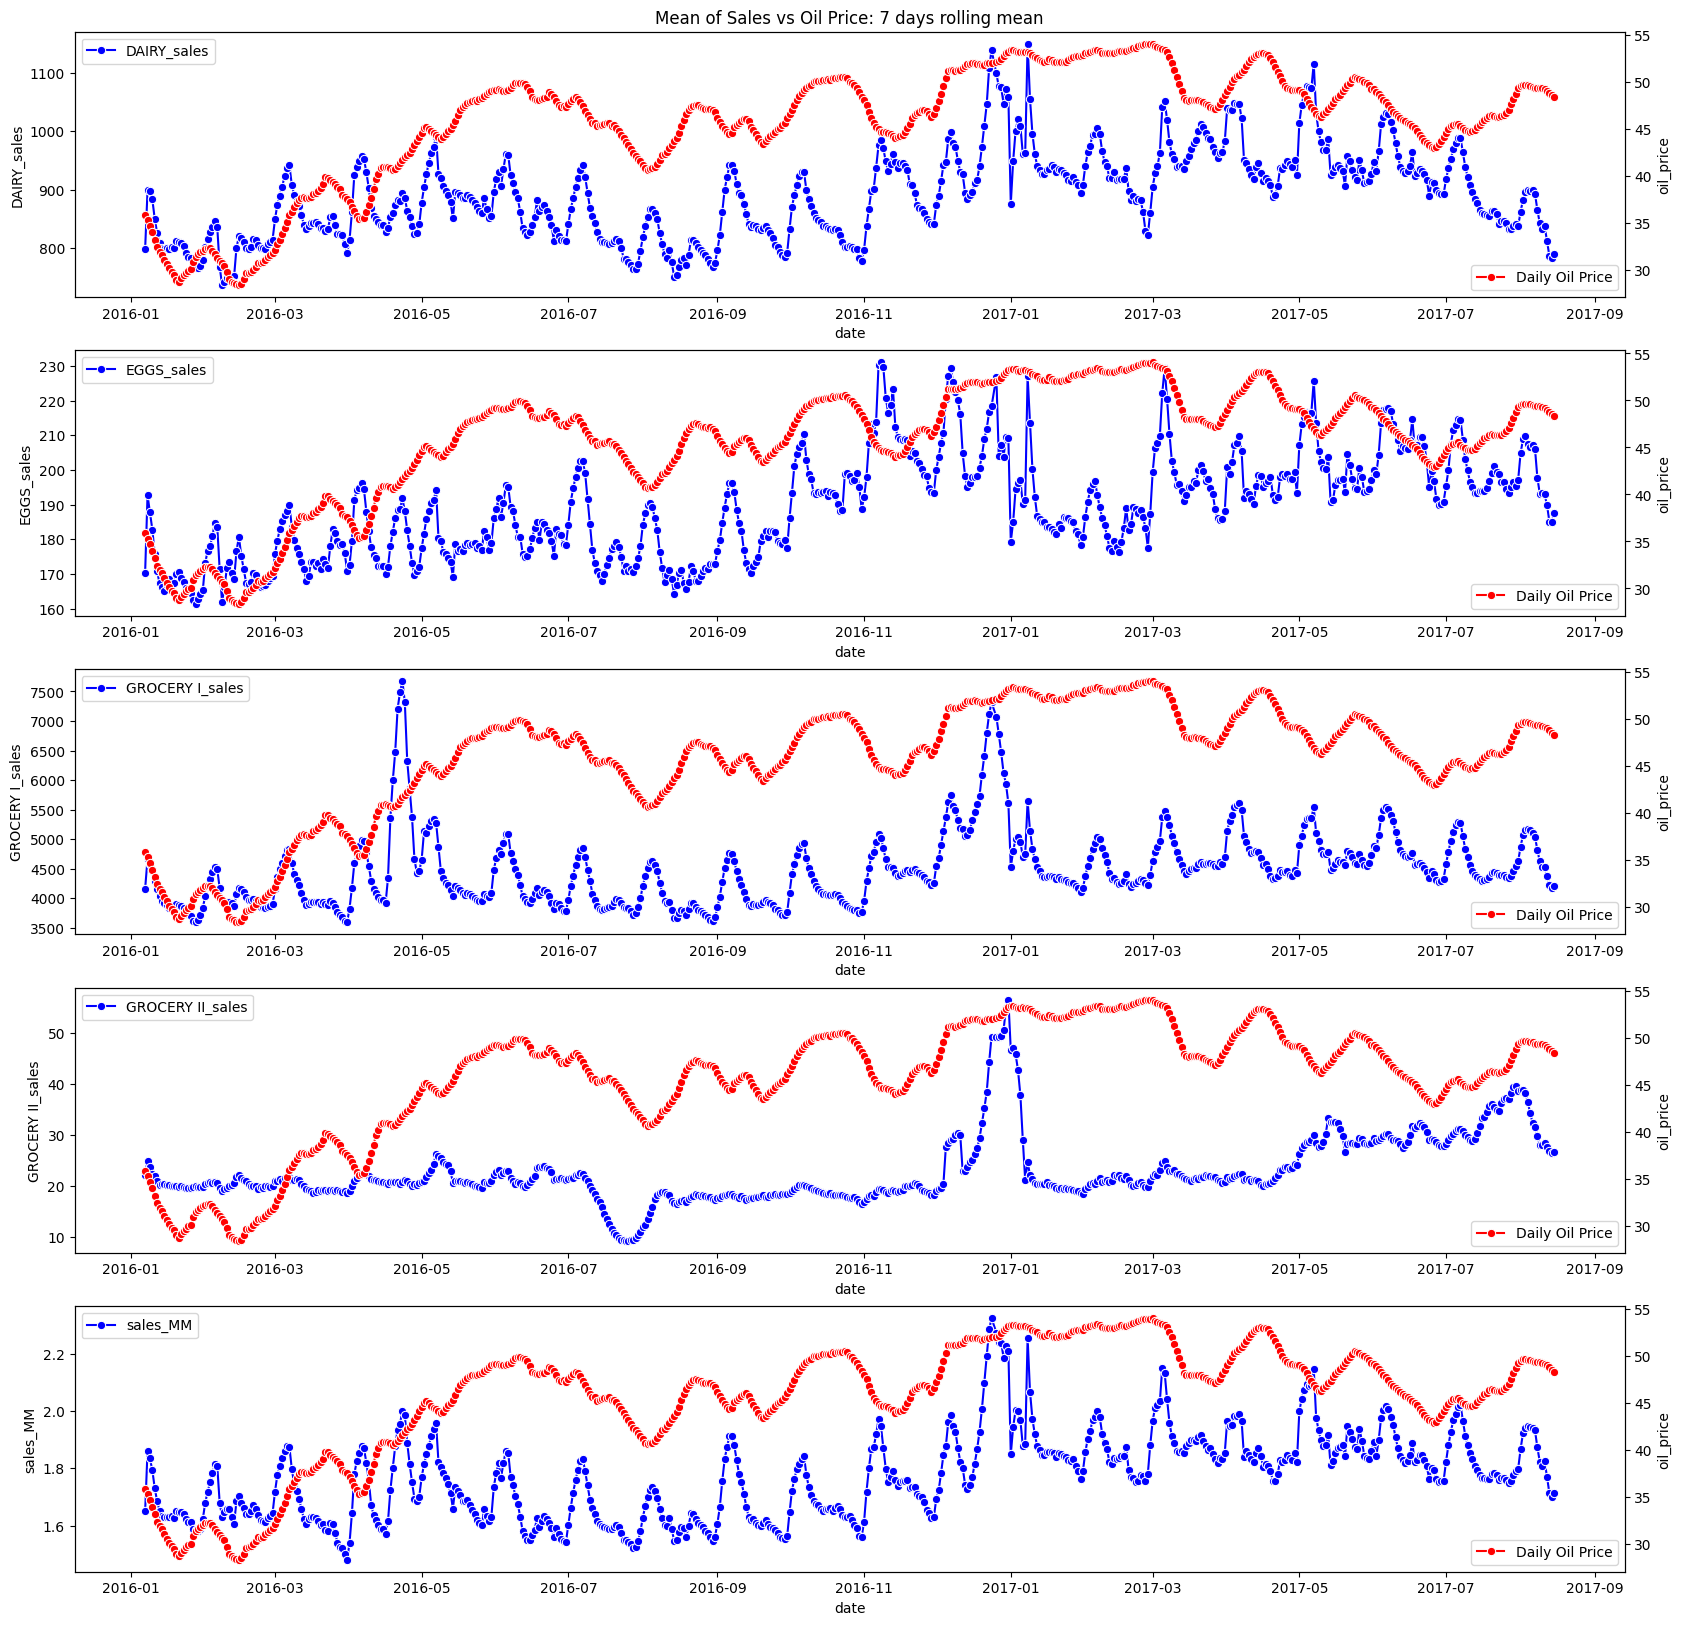

In [ ]:
def show_sales_against_oil(df, families=ana_families, rolling_window_len=7):
  df = df.groupby('date').agg(
    {col: 'mean' for col in families + ['oil_price']}
  ).rolling(rolling_window_len).mean()
  nrows = len(families)
  fig, ax = plt.subplots(nrows=nrows, ncols=1, figsize=(20,4*nrows))
  ax[0].set_title(f'Mean of Sales vs Oil Price: {rolling_window_len} days rolling mean')
  for i in range(nrows):
    ax_i = ax[i]
    y = families[i]
    sns.lineplot(x='date', y=y, data=df,
              color='blue', label=f'{y}',
              marker='o', ax=ax_i)
    ax_i.legend(loc='upper left')
    ax2 = ax_i.twinx()
    sns.lineplot(x='date', y='oil_price', data=df,
              color='red', label='Daily Oil Price',
              marker='o', ax=ax2)
    ax2.legend(loc='lower right')
  plt.show()

show_sales_against_oil(df_ana, rolling_window_len=7,
                       families=ana_families + ['sales_MM'])

## Daily sales vs Promotions per product category and Store

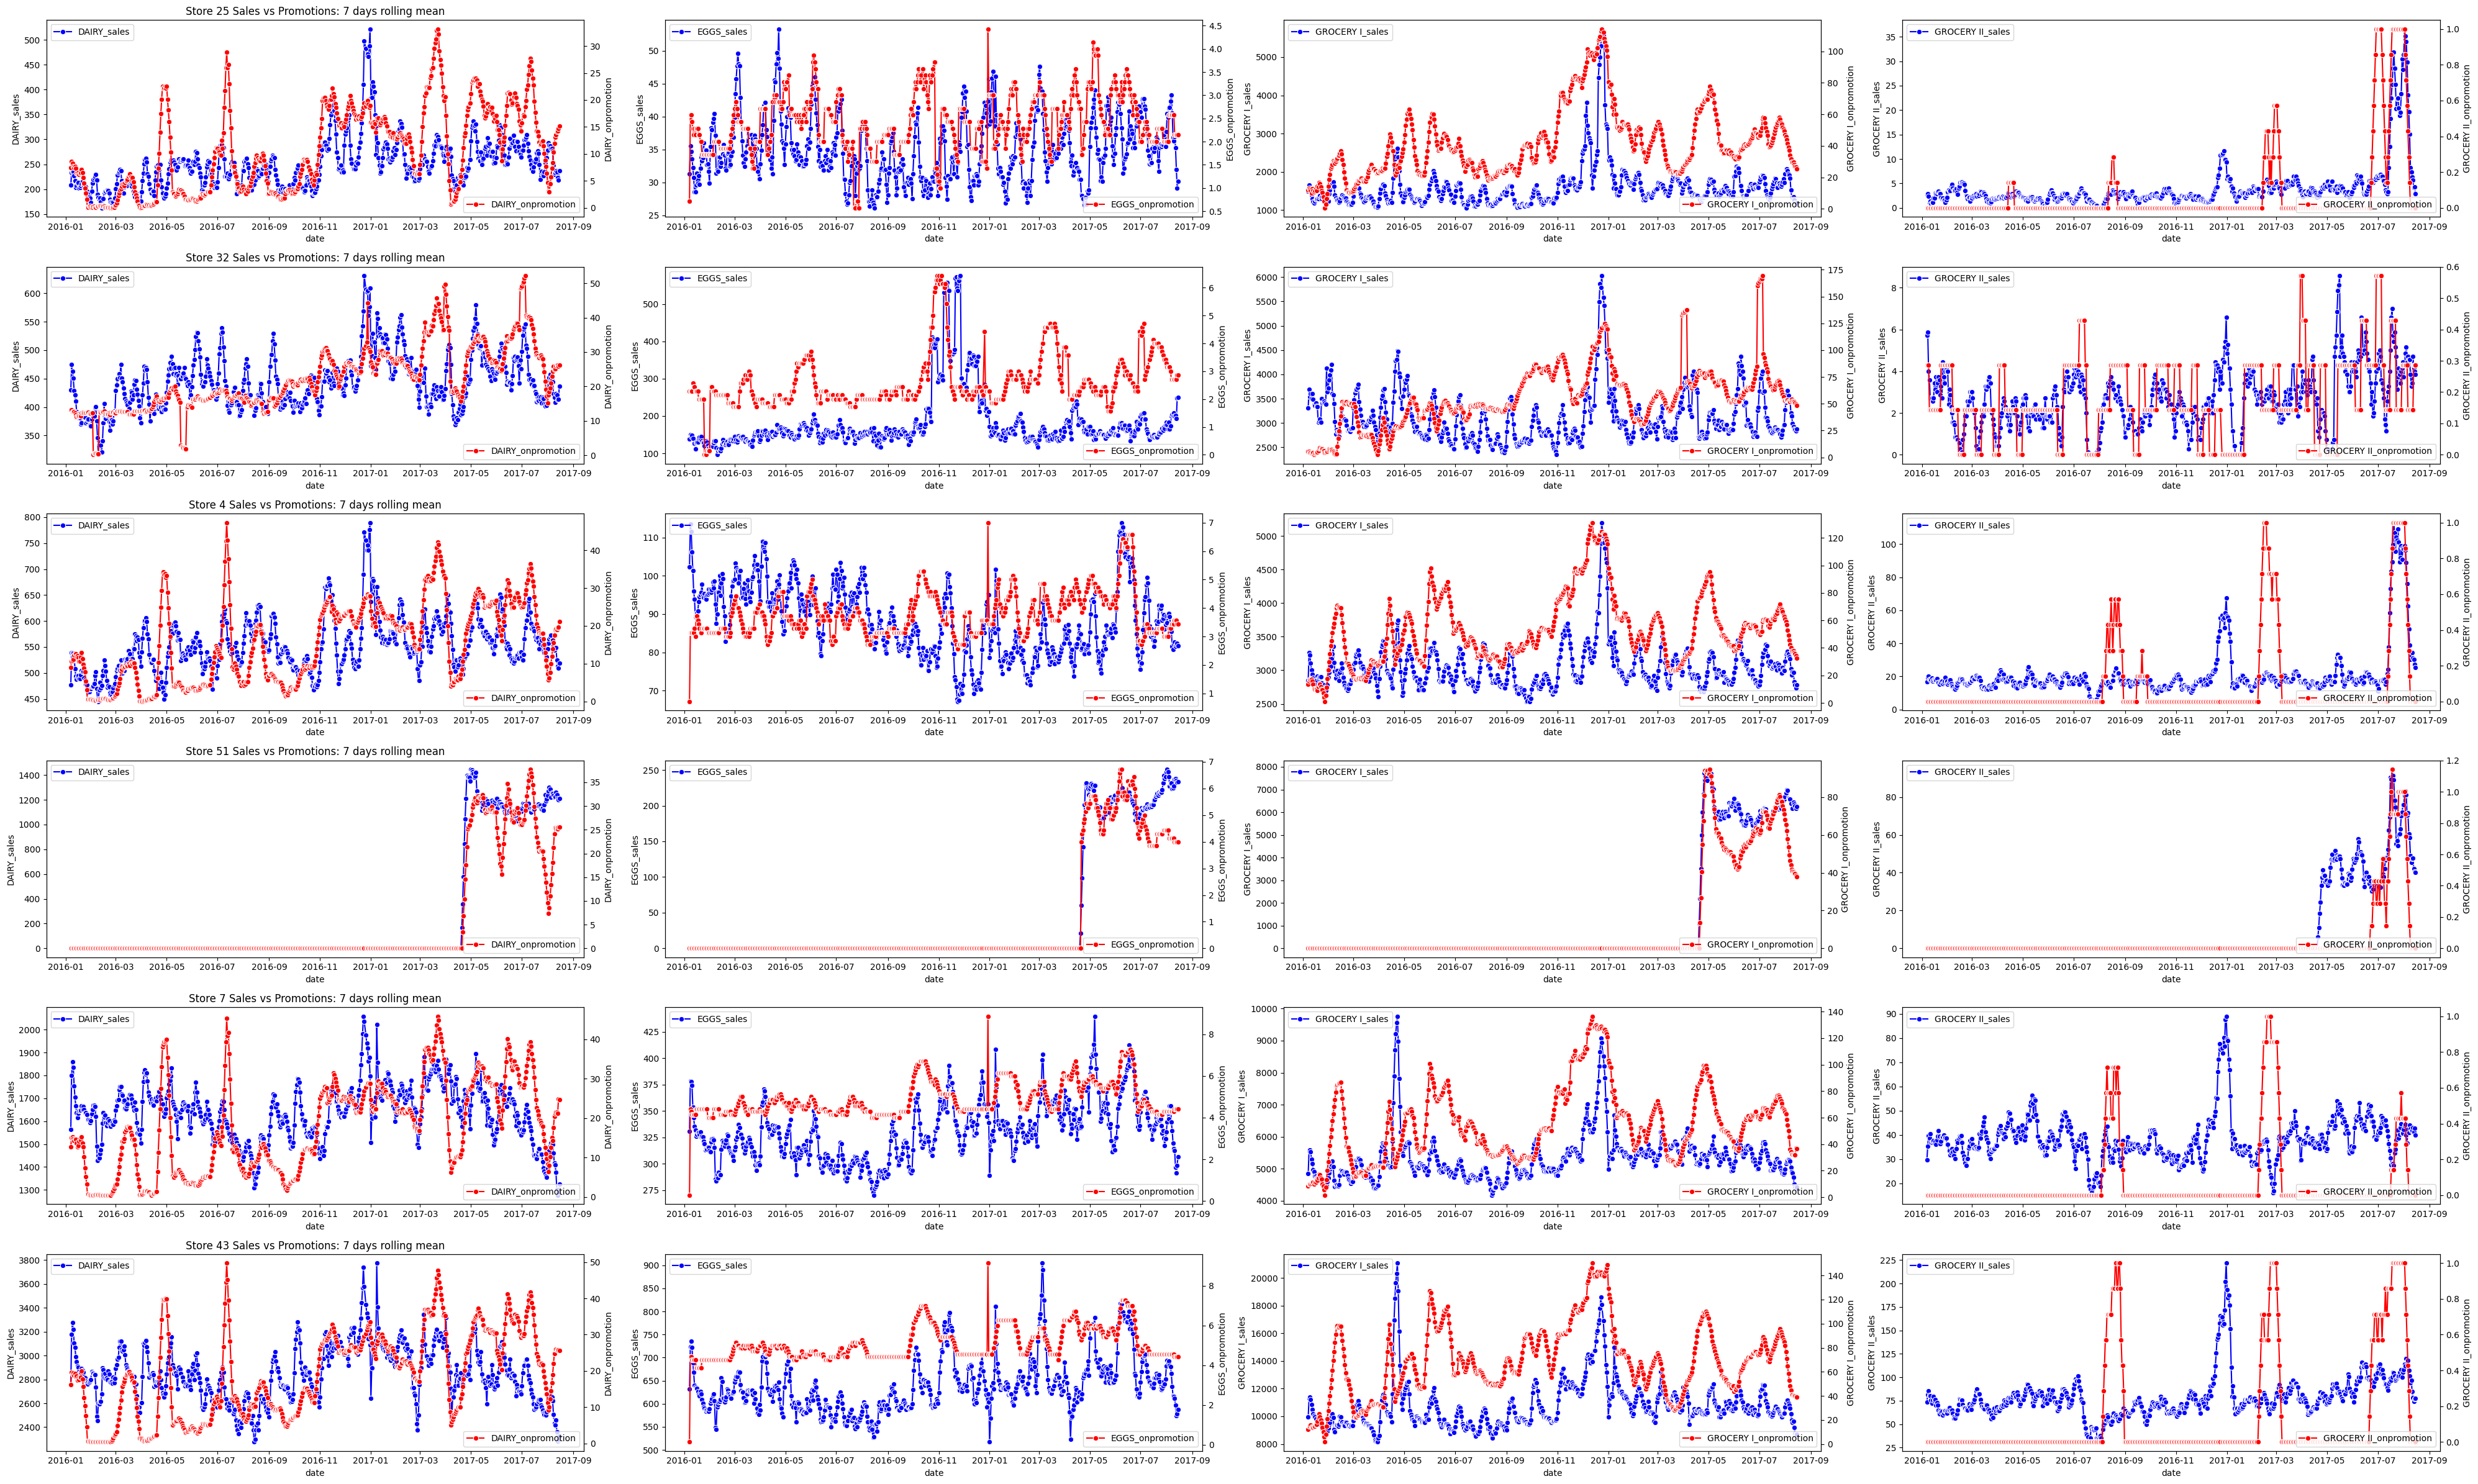

In [ ]:
def show_sales_against_promotions(df, rolling_window_len=7,
                                  families=ana_families, stores=ana_stores):
  promos = [sale_column.replace('_sales', '_onpromotion') for sale_column in families]
  df = df[df.store_nbr.isin(stores)]
  nrows = len(stores)
  ncols = len(families)
  fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10*ncols,4*nrows))
  for i, store in enumerate(stores):
    df_store = df[df.store_nbr == store]
    df_store = df_store.groupby('date').agg(
      {col: 'sum' for col in families + promos}
    ).rolling(rolling_window_len).mean()
    ax[i, 0].set_title(f'Store {store} Sales vs Promotions: {rolling_window_len} days rolling mean')
    for j, (fam, promo) in enumerate(zip(families, promos)):
      ax_i = ax[i,j]
      sns.lineplot(x='date', y=fam, data=df_store,
                color='blue', label=f'{fam}',
                marker='o', ax=ax_i)
      ax_i.legend(loc='upper left')
      ax2 = ax_i.twinx()
      sns.lineplot(x='date', y=promo, data=df_store,
                color='red', label=f'{promo}',
                marker='o', ax=ax2)
      ax2.legend(loc='lower right')
  plt.tight_layout()
  plt.show()
show_sales_against_promotions(df_ana, rolling_window_len=7)

## Analysis Insights Summary

The analysis revealed several key insights:

- **Autocorrelation and Seasonality:** There is notable autocorrelation with lags at 1, 6, 7, and 14 days, and a clear weekly seasonality. Differencing may be beneficial for specific combinations of stores and product families.
- **Sales Trends:** Sales increase towards the end of the week and peak in December, with monthly sales patterns being relatively similar. Sales are higher at the beginning of the month, with the middle of the month showing less influence.
- **Geographical and Store Insights:** City-level data is more granular and varied than state-level data, though they encode similar information. Clustering of stores reflects store size, with store types B and E showing similar sales patterns. All stores were open at the end of the training period, but some were newly opened in 2017.
- **Outliers:** The number of outliers is small.
- **External Factors:** There is no obvious correlation between oil prices and the scaled sum of sales across all stores, though some product families show sensitivity to oil price changes.
- **Promotions:** Onpromotion data per family is a valuable feature, capturing both seasonality and quantity effectively.

**These insights inform the design of the neural network architecture.**

# PyTorch Multiple Regression Model

## Building

In [ ]:
import torch
import torch.nn as nn

import torch.optim as optim
if torch.cuda.is_available():
  print('Using cuda on GPU')
  device = torch.device('cuda')
  ! nvidia-smi
else:
  device = 'cpu'
pl.seed_everything(SEED)

Using cuda on GPU
Wed Jul  3 21:21:03 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   43C    P8             11W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------

42

### Embed categorical features

In [ ]:
class StoreEmbeddingLayer(nn.Module):
  def __init__(self, emb_in: list[int], emb_out: list[int], num_feat_aux: int):
    super(StoreEmbeddingLayer, self).__init__()
    self.embedding_layers = nn.ModuleList([
        nn.Embedding(n_in, n_out) for n_in, n_out in zip(emb_in, emb_out)
    ])
    self.total_num_in = sum(emb_out) + num_feat_aux
    self.total_num_out = round(self.total_num_in / 2)
    self.fc = nn.Sequential(
            nn.Linear(self.total_num_in, self.total_num_out),
            nn.ReLU(),
            nn.BatchNorm1d(self.total_num_out),
            nn.Dropout(0.2)
        )

  def forward(self, emb_data_list: list[torch.tensor], aux_data: torch.tensor):
    emb_data_list = [emb_layer(x) for emb_layer, x in zip(self.embedding_layers, emb_data_list)]
    emb_data_list.append(aux_data)
    return self.fc(torch.cat(emb_data_list, dim=1))

  def number_of_output_neurons(self):
    return self.total_num_out

### Build Dataset and Data Module

In [ ]:
from torch.utils.data import DataLoader, Dataset
class SalesDataset(Dataset):
  def __init__(self, tensor_seq: torch.Tensor, tensor_hist: torch.Tensor,
               tensors_emb: list[torch.Tensor], tensor_aux: torch.Tensor,
               df: pd.DataFrame):
    self.tensor_seq = tensor_seq
    self.tensor_hist = tensor_hist
    self.tensors_emb = tensors_emb
    self.tensor_aux = tensor_aux
    self.df = df

  def __len__(self):
    return self.tensor_seq.shape[0]

  def __getitem__(self, i):
    seq = self.tensor_seq[i]
    hist = self.tensor_hist[i]
    emb = [tensor[i] for tensor in self.tensors_emb]
    aux = self.tensor_aux[i]
    return seq, hist, emb, aux

class SalesTrainingDataset(SalesDataset):
  def __init__(self, tensor_seq: torch.Tensor, tensor_hist: torch.Tensor,
               tensors_emb: list[torch.Tensor], tensor_aux: torch.Tensor,
               target: torch.Tensor, df: pd.DataFrame):
    super().__init__(tensor_seq, tensor_hist, tensors_emb, tensor_aux, df)
    self.target = target

  def __getitem__(self, i):
    batch = super().__getitem__(i)
    target = self.target[i]
    return *batch, target

  def last_n(self, n: int):
    seq = self.tensor_seq[-n:].contiguous()
    hist = self.tensor_hist[-n:].contiguous()
    emb = [t[-n:].contiguous() for t in self.tensors_emb]
    aux = self.tensor_aux[-n:].contiguous()
    target = self.target[-n:].contiguous()
    df = self.df[-n:]
    return SalesTrainingDataset(seq, hist, emb, aux, target, df)

feat_fourier = [feat for feat in fourier_columns if feat not in [
    'sin_M_1'
]]
feat_date=['year']
feat_bool=['is_post_payment_date', 'is_free']
feat_store_aux = ['population_city', 'population_state'] # external info
feat_onehot = ['store_type']
feat_numeric = ['store_size', 'cluster', 'oil_price']
# Embedding dimensions
feat_store_emb = ['store_nbr', 'store_type',
                  'city', 'state']
feat_store_emb_out = [32, 4, 8, 4] # dims in embedding space
feat_store_emb_in = [len(col.unique()) for col in [
    df_store.store_nbr, df_store.store_type,
    df_store.city, df_store.state]]

In [ ]:
class SalesDataModule(pl.LightningDataModule):
  def __init__(self, hist_len: int, batch_size: int, num_val_days: int,
               preprocessor: DataPipeline, feat_seq: list[str],
               df_train=df_train, df_pred=df_test,
               feat_emb=feat_store_emb, feat_aux=feat_store_aux,
               target_columns=sales_columns, device=None, dtype=torch.float32):
    super().__init__()
    self.df_train = df_train
    self.df_pred = df_pred
    self.num_stores = len(df_pred.store_nbr.unique())
    self.target_columns = target_columns
    self.feat_seq = feat_seq
    self.hist_len = hist_len
    self.feat_emb = feat_emb
    self.feat_aux = feat_aux
    self.batch_size = batch_size
    self.num_val_days = num_val_days
    self.train = None
    self.pred = None
    self.num_days_pred = None
    self.device = device
    self.dtype = dtype
    self.preprocessor = preprocessor

  def setup(self, stage: str):
    if stage == 'fit':
      self.train, self.pred = self._setup_validation()
    elif stage == 'predict':
      self.train, self.pred = self._setup_prediction()

  def _setup_validation(self):
    val_split_date = self.df_train['date'].max() - pd.DateOffset(days=self.num_val_days-1)
    df_train, df_val = split_by_date(self.df_train,
      year=val_split_date.year, month=val_split_date.month, day=val_split_date.day)
    df_train = self.preprocessor.fit_transform(df_train)
    df_val = self.preprocessor.transform(df_val, include_sales=True)
    self.num_days_pred = len(df_val.date.unique())
    train = self._prepare_training_tensors(df_train)
    val = self._prepare_prediction_tensors(df_train, df_val)
    target = self._prepare_target_tensor(df_val)
    return SalesTrainingDataset(*train, df_train), SalesTrainingDataset(*val, target, df_val)

  def _setup_prediction(self):
    df_train = self.preprocessor.fit_transform(self.df_train)
    df_pred = self.preprocessor.transform(self.df_pred, include_sales=False)
    self.num_days_pred = len(df_pred.date.unique())
    train = self._prepare_training_tensors(df_train)
    pred = self._prepare_prediction_tensors(df_train, df_pred)
    return SalesTrainingDataset(*train, df_train), SalesDataset(*pred, df_pred)

  def _prepare_tensor(self, data, dtype=None):
    if dtype is None:
      dtype = self.dtype
    return torch.tensor(data, device=self.device, dtype=dtype)

  def _prepare_target_tensor(self, df):
    return self._prepare_tensor(df[self.target_columns].values)

  def prepare_emb_aux_tensors(self, df):
    emb = [self._prepare_tensor(df[feat].values, torch.int) for feat in self.feat_emb]
    aux = self._prepare_tensor(df[self.feat_aux].values)
    return emb, aux

  def _prepare_training_tensors(self, df):
    # hist is a tensor of shape
    # (num_samples, hist_len+1, len(feat_seq + target_columns))
    hist = self._create_windows(df, self.feat_seq + self.target_columns,
                                remove_first_window=False)
    hist, seq = torch.tensor_split(hist, (-1, ), dim=1)
    seq = seq[:, 0, :] # last row is the actual feature and target data
    seq, target = torch.tensor_split(seq, (len(self.feat_seq), ), dim=1)
    emb, aux = self.prepare_emb_aux_tensors(df)
    return seq, hist, emb, aux, target

  def _prepare_prediction_tensors(self, df_train, df_pred):
    hist = self._prepare_prediction_hist_tensor(df_train, df_pred)
    seq = self._prepare_tensor(df_pred[self.feat_seq].values)
    emb, aux = self.prepare_emb_aux_tensors(df_pred)
    return seq, hist, emb, aux

  def _prepare_prediction_hist_tensor(self, df_train, df_pred):
    feat_hist = self.feat_seq + self.target_columns
    num_feat_hist = len(feat_hist)
    hist_len = self.hist_len
    hist = np.zeros((len(df_pred), hist_len, num_feat_hist))
    recent = np.zeros((self.num_stores, hist_len, num_feat_hist))
    for store, store_data in df_train.groupby('store_nbr'):
      recent_store = store_data.tail(hist_len)[feat_hist].values
      pad = recent_store[0:1].repeat(repeats=hist_len-len(recent_store), axis=0)
      recent[store, :, :]  = np.concatenate((pad, recent_store), axis=0)
    for day in range(min(hist_len, self.num_days_pred)):
      day_idx = day * self.num_stores
      num_days_train = hist_len - day
      hist[day_idx: (day_idx + self.num_stores), 0:num_days_train, :] = recent[
          :,  -num_days_train:, :]
    return self._prepare_tensor(hist)

  def _sort_index_switch_store_date(self, df, days_to_remove):
    # gets an index which resorts the order from (store_nbr, date) to (date, store_nbr)
    df = df[['store_nbr', 'date']].sort_values(
        by=['date', 'store_nbr']).reset_index(drop=True)
    rows_per_store = []
    for store, store_data in df.groupby('store_nbr'):
      rows_per_store.append(store_data[days_to_remove:])
    df = pd.concat(rows_per_store).reset_index(drop=True)
    return df.sort_values(by=['date', 'store_nbr']).index

  def _create_windows(self, df, columns, remove_first_window=False):
    # Initialize the list to hold windowed data of shape (window_len, num_features)
    windows, window_len = [], self.hist_len + 1
    df = df.sort_values(by=['store_nbr', 'date'])
    df = df.reset_index(drop=True)
    stores = sorted(df['store_nbr'].unique())
    start_index = window_len if remove_first_window else 0
    sort_index = self._sort_index_switch_store_date(df,
      days_to_remove=start_index)

    for store in stores:
      store_data = df[df['store_nbr'] == store]
      store_data = store_data[columns].to_numpy()

      # Create sliding windows for the store
      for i in range(start_index, len(store_data)):
        if remove_first_window or i >= window_len - 1:
          start = i - window_len + 1
          window = store_data[start:(i+1), :]
        else:
          pad = store_data[0:1].repeat(window_len - i - 1, 0)
          window = store_data[0:(i+1), :]
          window = np.vstack((pad, window))
        windows.append(window)

    # Convert to sorted PyTorch tensor
    windows = np.array(windows).take(sort_index, axis=0)
    return self._prepare_tensor(windows)

  def get_transformed_train(self, num_days_past):
    return self.train.df[-num_days_past*self.num_stores:]
  def get_transformed_pred(self):
    return self.pred.df
  def inverse_transform(self, df, unseen: bool):
    return self.preprocessor.inverse_transform_target(df, unseen=unseen)

  def _dataset_loader(self, dataset, batch_size, num_workers=1):
    return DataLoader(dataset, batch_size=batch_size, shuffle=False,
                      num_workers=num_workers)
  def train_dataloader(self):
    return self._dataset_loader(self.train, batch_size=self.batch_size, num_workers=3)
  def val_dataloader(self):
    return self._dataset_loader(self.pred, batch_size=self.num_stores)
  def train_pred_dataloader(self, days=28):
    train = self.train.last_n(self.num_stores * days)
    return self._dataset_loader(train, batch_size=self.num_stores)
  def prediction_dataloader(self):
    return self._dataset_loader(self.pred, batch_size=self.num_stores)
  def add_autoregression(self, day: int, pred_day: torch.Tensor):
    # pred_day.shape==(num_stores, hist_len, len(feat_seq+sales_columns))
    hist = self.pred.tensor_hist
    for fut in range(day + 1, self.num_days_pred):
      if fut - day > self.hist_len:
        break
      fut_idx = fut * self.num_stores
      next_fut_idx = fut_idx + self.num_stores
      hist_idx = self.hist_len - (fut-day)
      hist[fut_idx: next_fut_idx, hist_idx, :] = pred_day

In [ ]:
pipe = DataPipeline(
  feat_minmax=feat_date+feat_bool,
  feat_onehot=['store_type'],
  feat_ordinal=['store_type', 'city', 'state'],
  feat_std=feat_numeric+feat_store_aux,
  feat_pass=feat_fourier+['date', 'store_nbr'],
  feat_storewise=onpromotion_columns,
  filter_closed_outlier=False,
  apply_power=True,
  apply_scaling=True,
  diff_period=0,
  lag_period=0
)
feat_onehot = ['store_type_' + c for c in 'BCDE'] # Drop type A
feat_seq = feat_date + feat_fourier + feat_bool + feat_onehot + feat_numeric + onpromotion_columns + pipe.feat_lag
start_day = pd.Timestamp(year=2016, month=1, day=1)
model = None # clear up RAM and old reference to datamodule
datamodule = SalesDataModule(hist_len=24*7, batch_size=2**13, # 2**13 optimal for 15 GB GPU from Colab
                            num_val_days=31,
                            preprocessor=pipe, feat_seq=feat_seq,
                            df_train=df_train[df_train.date >= start_day]
                            )
datamodule.setup('fit')

### Build Lightning Recurrent NN Module

In [ ]:
class RMSLE: # root-mean-squared-log-error
  @staticmethod
  def loss(pred, actual):
    pred = torch.log(torch.clip(pred, 1e-10, None) + 1.)
    actual = torch.log(torch.clip(actual, 1e-10, None) + 1.)
    return torch.abs(torch.sqrt(torch.mean(torch.square(pred - actual))))

  def loss_df(pred, actual, target_columns=sales_columns):
    pred =  torch.tensor(pred[target_columns].values)
    actual = torch.tensor(actual[target_columns].values)
    return RMSLE.loss(pred, actual)

class SalesPredictionModel(pl.LightningModule):
  def __init__(self, lr: float, datamodule: SalesDataModule, emb_in=feat_store_emb_in, emb_out=feat_store_emb_out, num_target=len(sales_columns),
               num_feat_seq=len(feat_seq), num_feat_aux=len(feat_store_aux),
               dense_hidden_size=256, dropout=0.25,
               recurrent_num_layers=2, recurrent_past_out=[1], recurrent_hidden_size=len(sales_columns)):
    super().__init__()
    self.lr = lr
    self.emb_layer = StoreEmbeddingLayer(emb_in, emb_out, num_feat_aux)
    self.recurrent = nn.LSTM(
        input_size=num_feat_seq + num_target,
        hidden_size=recurrent_hidden_size,
        batch_first=True, num_layers=recurrent_num_layers, dropout=dropout
    )
    self.recurrent_past_out = recurrent_past_out
    self.h_0, self.c_0 = None, None # (num_layers, num_stores, hidden_size) saves state of last predicted day
    num_emb_out = self.emb_layer.number_of_output_neurons()
    # Final layers combine embeddings with recurrent layers and give positive sale
    self.combined_dense = nn.Sequential(
        nn.Linear(num_feat_seq + len(
            recurrent_past_out) * recurrent_hidden_size + num_emb_out,
                  dense_hidden_size),
        nn.ReLU(),
        nn.BatchNorm1d(dense_hidden_size),
        nn.Dropout(dropout),
        nn.Linear(dense_hidden_size, num_target),
        nn.Softplus()
    )
    self.datamodule = datamodule

  def configure_optimizers(self):
     return torch.optim.Adam(self.parameters(), lr=self.lr)

  def forward(self, seq, hist, emb, aux, recurrent_hidden_state=None):
    emb_aux = self.emb_layer(emb, aux)
    seq_hist, (self.h_0, self.c_0) = self.recurrent(hist, recurrent_hidden_state) # contains historical timesteps
    seq_hist = [seq_hist[:, -i, :] for i in self.recurrent_past_out] # get previous timesteps hidden representation
    out = self.combined_dense(torch.cat((seq, *seq_hist, emb_aux), dim=1))
    return out

  def get_store_embedding(self, emb: list[torch.Tensor], aux: torch.Tensor):
    return self.emb_layer(emb, aux)

  def get_recurrent_hidden_state(self, num_states):
    if self.h_0 is None:
      return None
    h_0 = self.h_0[:, -num_states:, :]
    c_0 = self.c_0[:, -num_states:, :]
    return (h_0.contiguous(), c_0.contiguous())
  def reset_recurrent_hidden_state(self):
    self.h_0 = None
    self.c_0 = None

  def training_step(self, batch, batch_idx):
    *batch, Y_actual = batch
    Y_pred = self(*batch)
    loss = RMSLE.loss(Y_pred, Y_actual)
    self.log('train_loss', loss, prog_bar=True)
    return loss

  def step_with_autoregression(self, batch, batch_idx):
    seq, hist, emb, aux  = batch[0], batch[1], batch[2], batch[3]
    Y_pred = self(seq, hist, emb, aux,
                  self.get_recurrent_hidden_state(seq.shape[0]))
    seq_pred = torch.concat((seq, Y_pred), dim=1)
    self.datamodule.add_autoregression(day=batch_idx, pred_day=seq_pred)
    return Y_pred

  def validation_step(self, batch, batch_idx):
   Y_pred = self.step_with_autoregression(batch, batch_idx)
   Y_actual = batch[4]
   loss = RMSLE.loss(Y_pred, Y_actual)
   self.log('val_loss', loss, prog_bar=True)
   return loss

  def predict_step(self, batch, batch_idx, dataloader_idx=0):
    return self.step_with_autoregression(batch, batch_idx)

model = SalesPredictionModel(0.001, datamodule)
print(model)
print(f'Number of Parameters: {sum(p.numel() for p in model.parameters())}')

SalesPredictionModel(
  (emb_layer): StoreEmbeddingLayer(
    (embedding_layers): ModuleList(
      (0): Embedding(54, 32)
      (1): Embedding(5, 4)
      (2): Embedding(22, 8)
      (3): Embedding(16, 4)
    )
    (fc): Sequential(
      (0): Linear(in_features=50, out_features=25, bias=True)
      (1): ReLU()
      (2): BatchNorm1d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Dropout(p=0.2, inplace=False)
    )
  )
  (recurrent): LSTM(87, 33, num_layers=2, batch_first=True, dropout=0.25)
  (combined_dense): Sequential(
    (0): Linear(in_features=112, out_features=256, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.25, inplace=False)
    (4): Linear(in_features=256, out_features=33, bias=True)
    (5): Softplus(beta=1, threshold=20)
  )
)
Number of Parameters: 66314


## Training and Prediction

### Find hyperparams with Validation Dataset

In [ ]:
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import EarlyStopping, StochasticWeightAveraging
logger = CSVLogger('logs', name='experiment', version=0)

learning_rate = 0.005
recurrent_num_layers = 3
recurrent_past_out = [1,7,14,21,28]
recurrent_hidden_size = len(sales_columns)
dense_hidden_size = 256
dropout = 0.25
model = SalesPredictionModel(datamodule=datamodule, lr=learning_rate,
                             recurrent_num_layers=recurrent_num_layers,
                             recurrent_past_out=recurrent_past_out,
                             recurrent_hidden_size=recurrent_hidden_size,
                             dense_hidden_size=dense_hidden_size,
                             dropout=dropout)
epochs = 30

accumulate_grad_batches = 1
gradient_clip_val = 10.0

early_stop_cb = EarlyStopping(
    monitor='val_loss', mode='min',
    patience=6, min_delta=0.0001,
    verbose=False,
)
swa_lrs = 1e-2
swa_cb = StochasticWeightAveraging(swa_lrs=swa_lrs)

trainer = pl.Trainer(max_epochs=epochs, callbacks=[swa_cb, early_stop_cb], deterministic='warn',
                     gradient_clip_val=gradient_clip_val, accumulate_grad_batches=accumulate_grad_batches,
                     default_root_dir=KAGGLE_WORKING_PATH, logger=logger, log_every_n_steps=1)
trainer.fit(model, train_dataloaders=datamodule.train_dataloader(),
            val_dataloaders=datamodule.val_dataloader())
torch.cuda.empty_cache() # avoids out of memory if trained again...

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

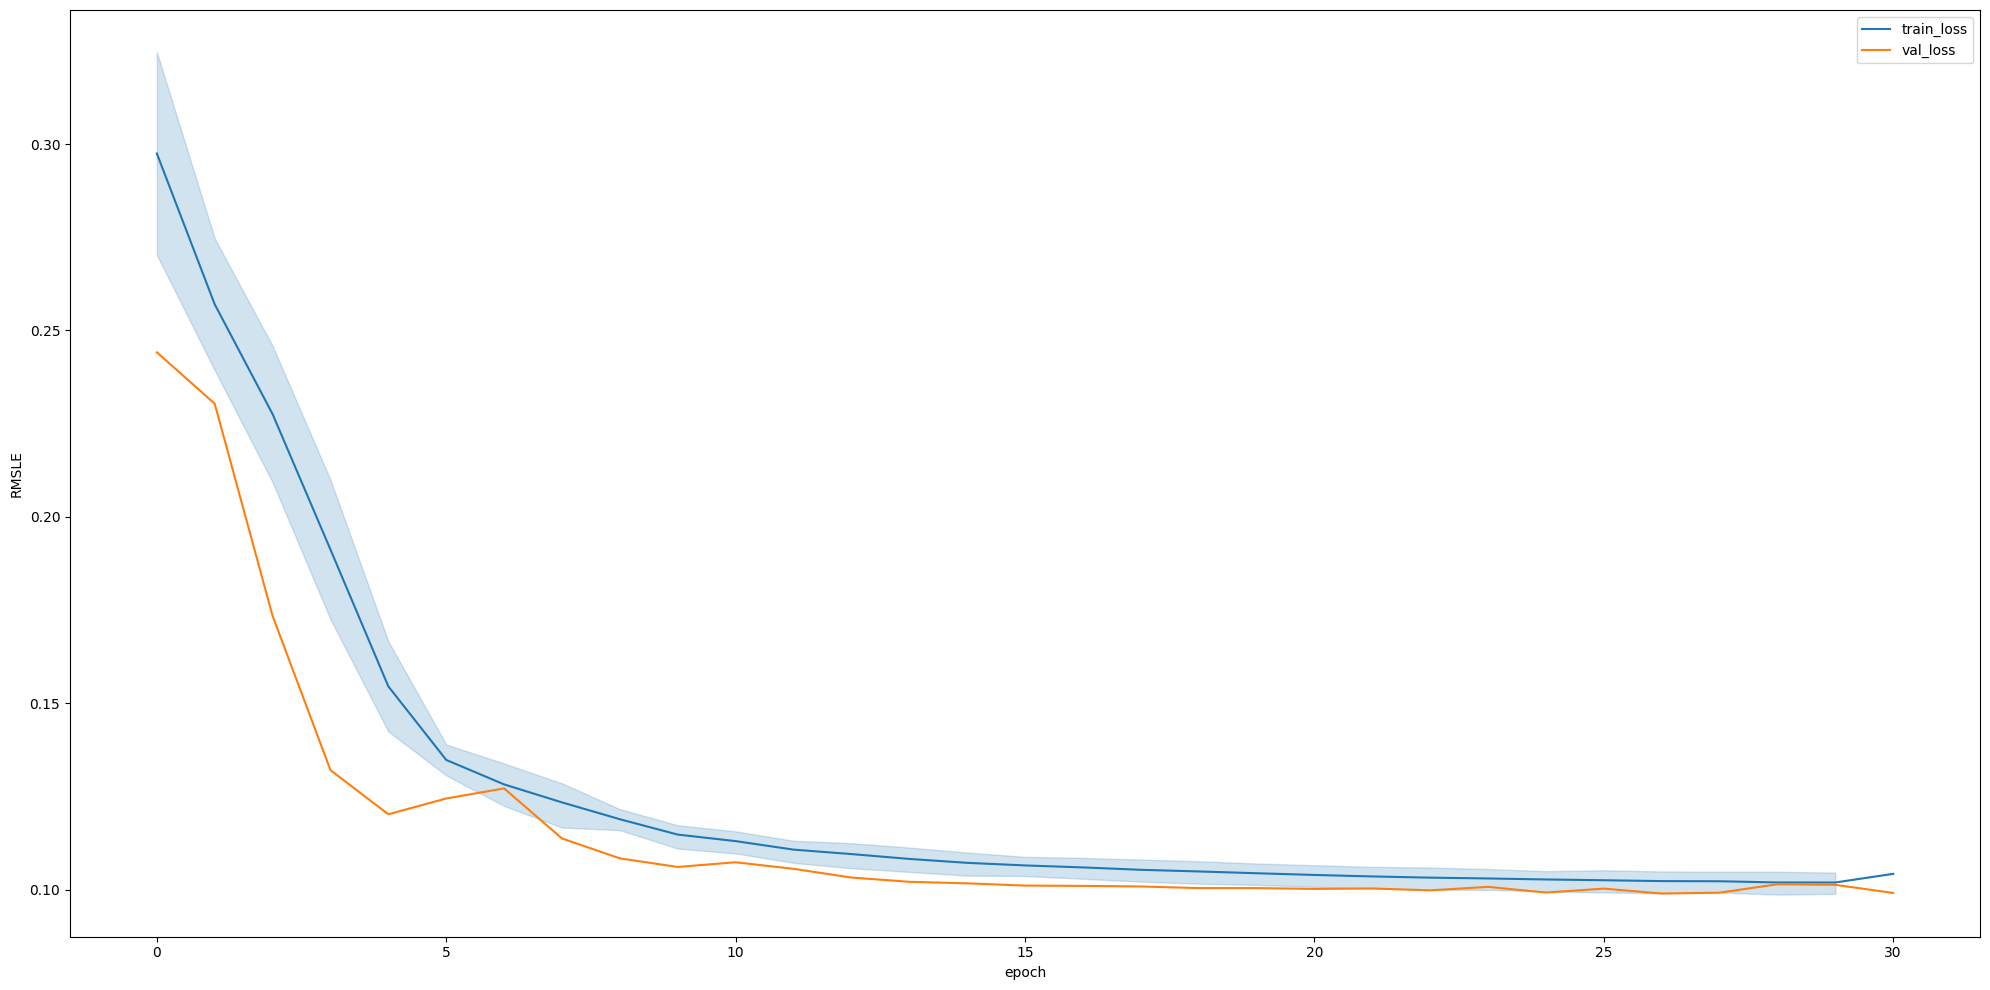

In [ ]:
def load_pl_logs(root_path=KAGGLE_WORKING_PATH,
                 project_name='Lightning',
                 version=0):
  log_path = os.path.join(root_path, f'logs/{project_name}/version_{version}/metrics.csv')
  return pd.read_csv(log_path)

def plot_metrics(metrics: pd.DataFrame, figsize=(20,10), x='epoch'):
  prog_columns = ['epoch', 'step']
  loss_columns = [col for col in list(metrics.columns) if 'loss' in col]
  plt.figure(figsize=figsize)
  for col in loss_columns:
    df = metrics[prog_columns + [col]].dropna()
    sns.lineplot(data=df, x=x, y=col, label=col)
  plt.xlabel(x)
  plt.ylabel('RMSLE')
  plt.tight_layout()
  plt.show()

plot_metrics(load_pl_logs(project_name='experiment'), x='epoch')

In [ ]:
def get_inverse_transformed_fit(model, trainer, datamodule, num_days_past=4*7, target_columns=sales_columns):
  include_columns = ['date', 'store_nbr']
  train = datamodule.get_transformed_train(num_days_past)
  val = datamodule.get_transformed_pred()
  train_pred, val_pred = train[include_columns].copy(), val[include_columns].copy()
  model.reset_recurrent_hidden_state()
  train_pred[target_columns] = np.concatenate(trainer.predict(
      model, dataloaders=datamodule.train_pred_dataloader(num_days_past)), axis=0)
  val_pred[target_columns] = np.concatenate(trainer.predict(
      model, dataloaders=datamodule.prediction_dataloader()), axis=0)
  print('Training Loss before inversion: ', RMSLE.loss_df(train_pred, train))
  print('Validation Loss before inversion: ', RMSLE.loss_df(val_pred, val))
  train = datamodule.inverse_transform(train, unseen=False)
  train_pred = datamodule.inverse_transform(train_pred, unseen=False)
  val = datamodule.inverse_transform(val, unseen=True)
  val_pred = datamodule.inverse_transform(val_pred, unseen=True)
  print('Training Loss AFTER inversion: ', RMSLE.loss_df(train_pred, train))
  print('Validation Loss AFTER inversion: ', RMSLE.loss_df(val_pred, val))
  return dict(train=train, val=val, train_pred=train_pred, val_pred=val_pred)

actual_pred = get_inverse_transformed_fit(model, trainer, datamodule, num_days_past=12*7)
# val AFTER 0.4482 (31 val days, 01.2016, 24*7 hist, no filtering (and no flags), 40 epochs)
df = actual_pred['val_pred']
df[(df[sales_columns]<0).any(axis=1)]

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Training Loss before inversion:  tensor(0.0967, dtype=torch.float64)
Validation Loss before inversion:  tensor(0.0992, dtype=torch.float64)
Training Loss AFTER inversion:  tensor(0.4289, dtype=torch.float64)
Validation Loss AFTER inversion:  tensor(0.4495, dtype=torch.float64)


Empty DataFrame
Columns: [date, store_nbr, AUTOMOTIVE_sales, BABY CARE_sales, BEAUTY_sales, BEVERAGES_sales, BOOKS_sales, BREAD/BAKERY_sales, CELEBRATION_sales, CLEANING_sales, DAIRY_sales, DELI_sales, EGGS_sales, FROZEN FOODS_sales, GROCERY I_sales, GROCERY II_sales, HARDWARE_sales, HOME AND KITCHEN I_sales, HOME AND KITCHEN II_sales, HOME APPLIANCES_sales, HOME CARE_sales, LADIESWEAR_sales, LAWN AND GARDEN_sales, LINGERIE_sales, LIQUOR,WINE,BEER_sales, MAGAZINES_sales, MEATS_sales, PERSONAL CARE_sales, PET SUPPLIES_sales, PLAYERS AND ELECTRONICS_sales, POULTRY_sales, PREPARED FOODS_sales, PRODUCE_sales, SCHOOL AND OFFICE SUPPLIES_sales, SEAFOOD_sales]
Index: []

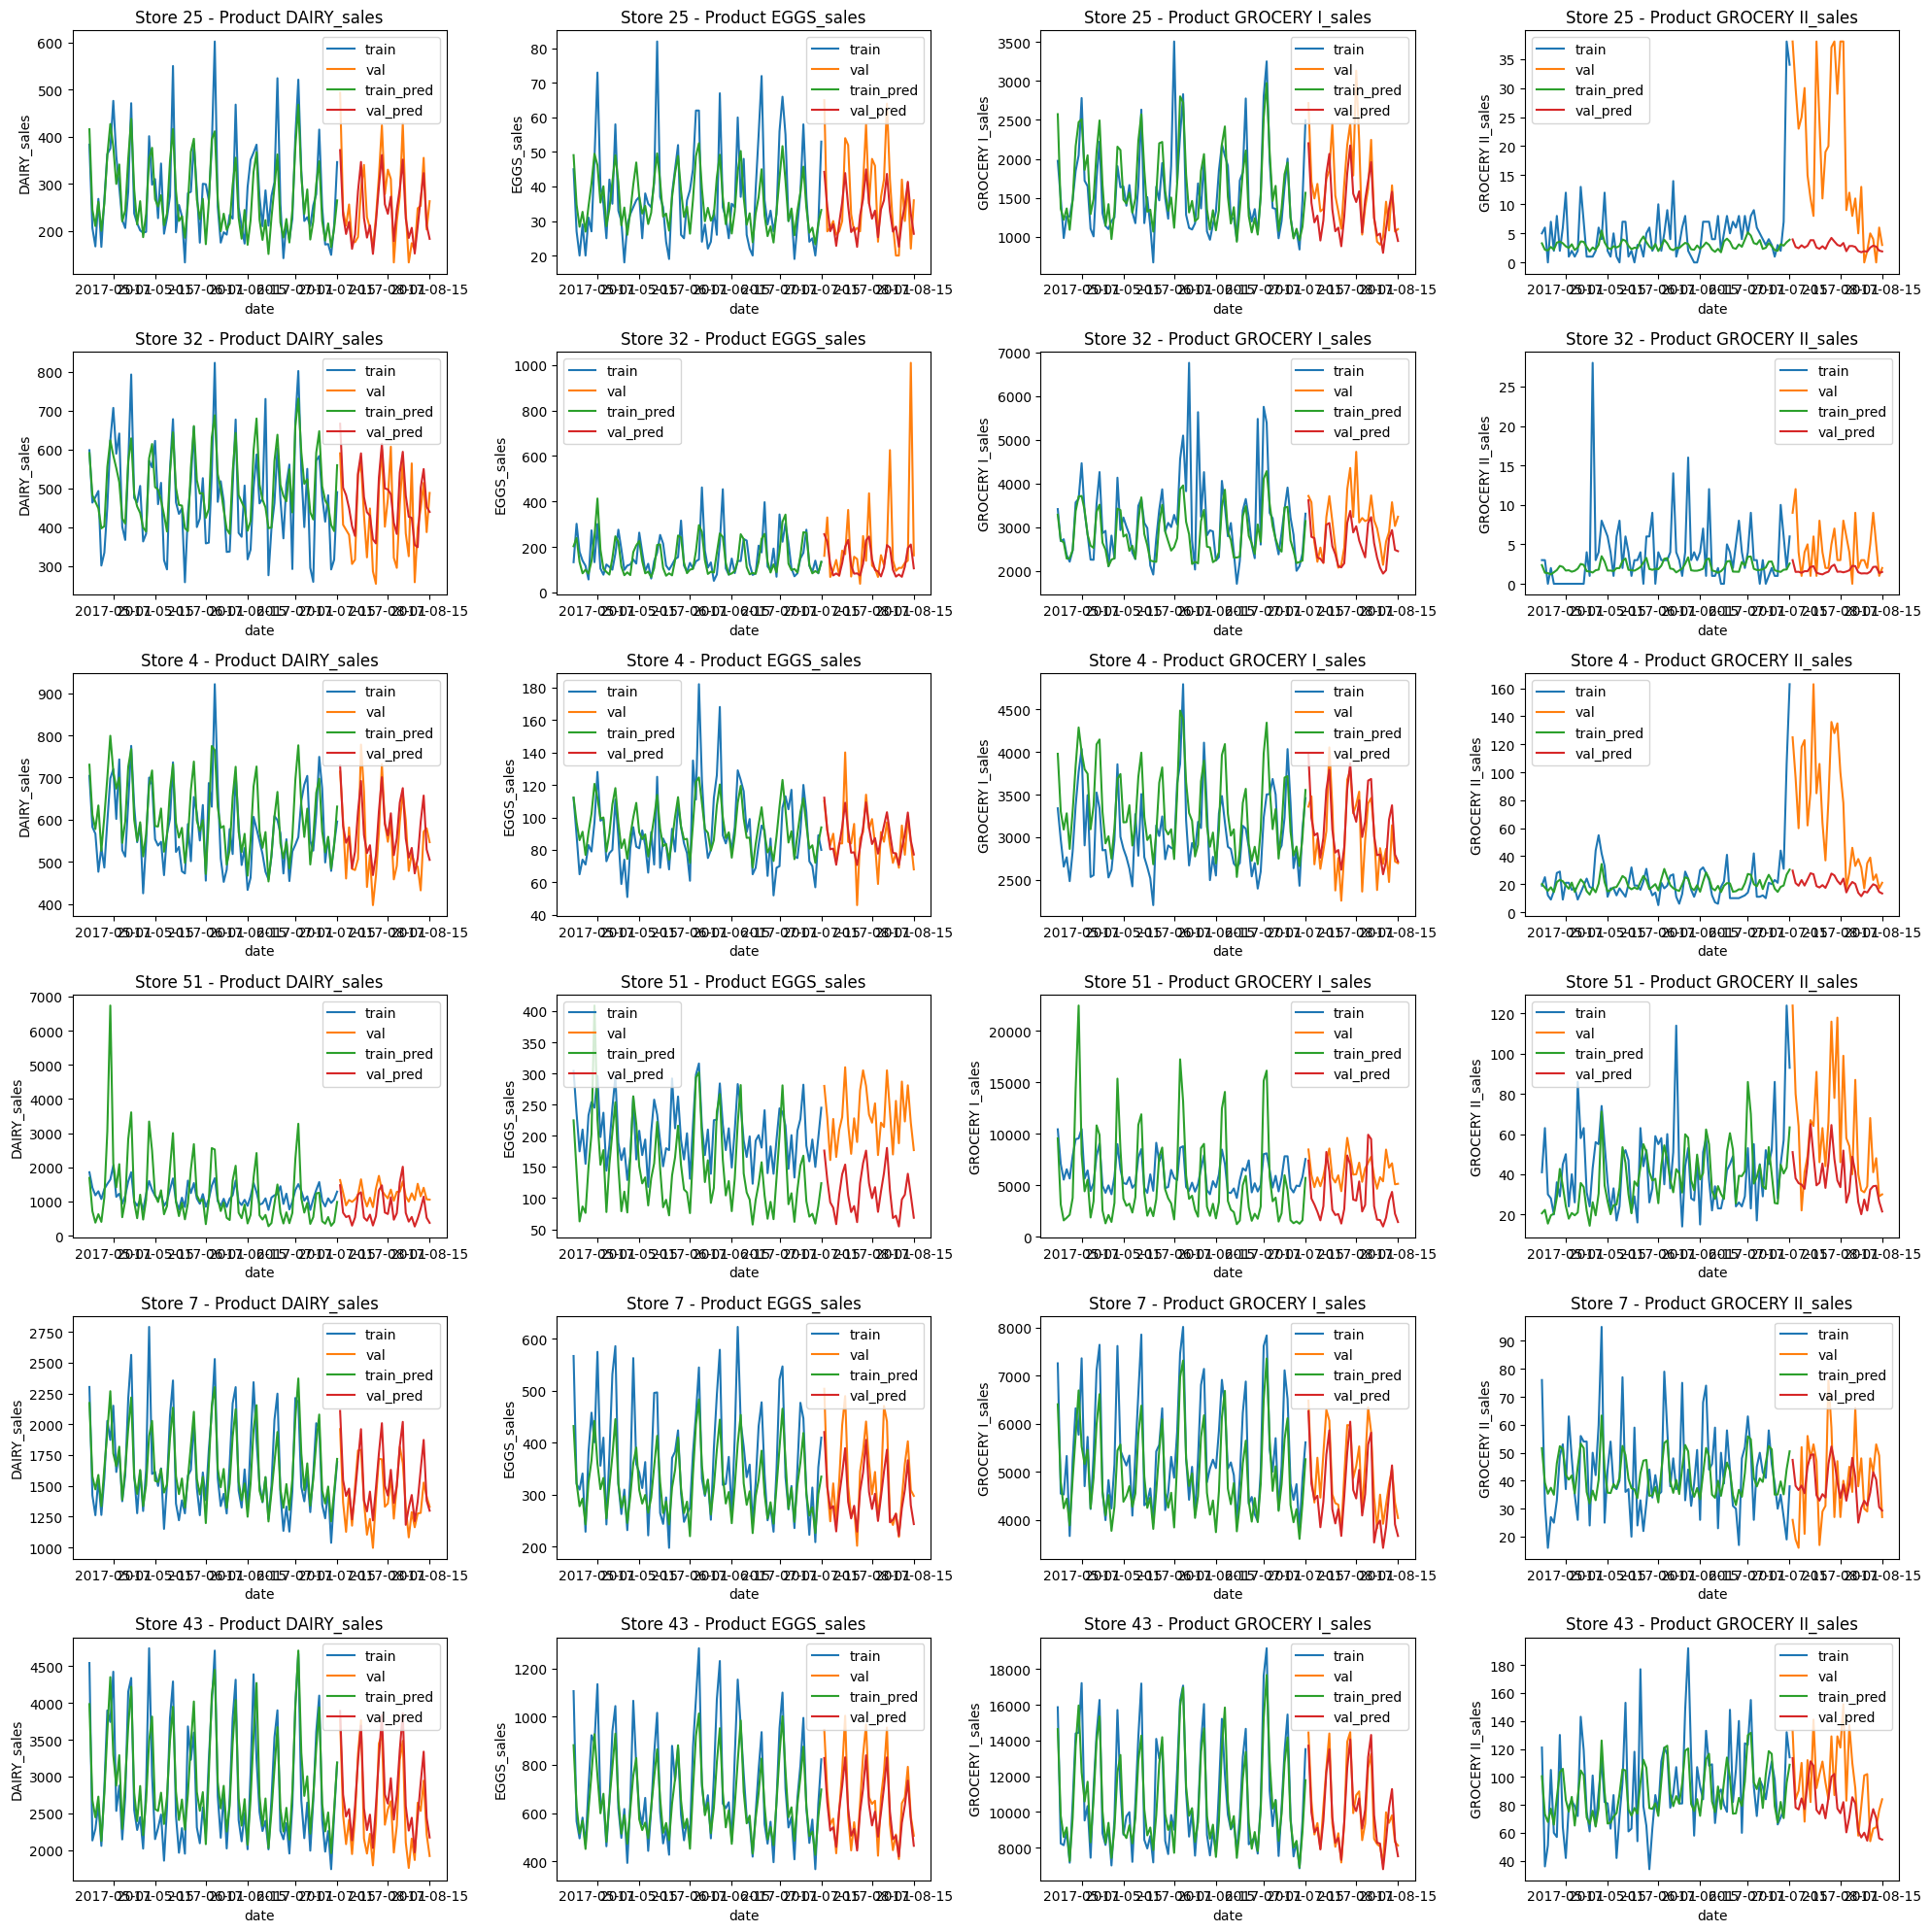

In [ ]:
def show_prediction(actual_pred: dict,
                    families=ana_families,
                    stores=ana_stores):
  nrows, ncols = len(stores), len(families)
  fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20))
  for i in range(nrows):
    for j in range(ncols):
      store, family = stores[i], families[j]
      filter = lambda df: df[(df.store_nbr == store)]
      ax_xy = ax[i,j]
      for label, df in actual_pred.items():
        sns.lineplot(x='date', y=family, data=filter(df), label=label, ax=ax_xy)
      ax_xy.set_title(f'Store {store} - Product {family}')
  plt.tight_layout()
show_prediction(actual_pred)

### Train Final Model on all data and forecast

In [ ]:
logger = CSVLogger('logs', name='prediction', version=0)
datamodule.setup('predict')
model = SalesPredictionModel(datamodule=datamodule, lr=learning_rate,
                             recurrent_num_layers=recurrent_num_layers,
                             recurrent_past_out=recurrent_past_out,
                             recurrent_hidden_size=recurrent_hidden_size,
                             dense_hidden_size=dense_hidden_size,
                             dropout=dropout)
swa_cb = StochasticWeightAveraging(swa_lrs=swa_lrs)
trainer = pl.Trainer(max_epochs=30, callbacks=[swa_cb],
                     gradient_clip_val=gradient_clip_val, accumulate_grad_batches=accumulate_grad_batches,
                     default_root_dir=KAGGLE_WORKING_PATH, logger=logger, log_every_n_steps=1)
trainer.fit(model, train_dataloaders=datamodule.train_dataloader())

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.


Training: |          | 0/? [00:00<?, ?it/s]

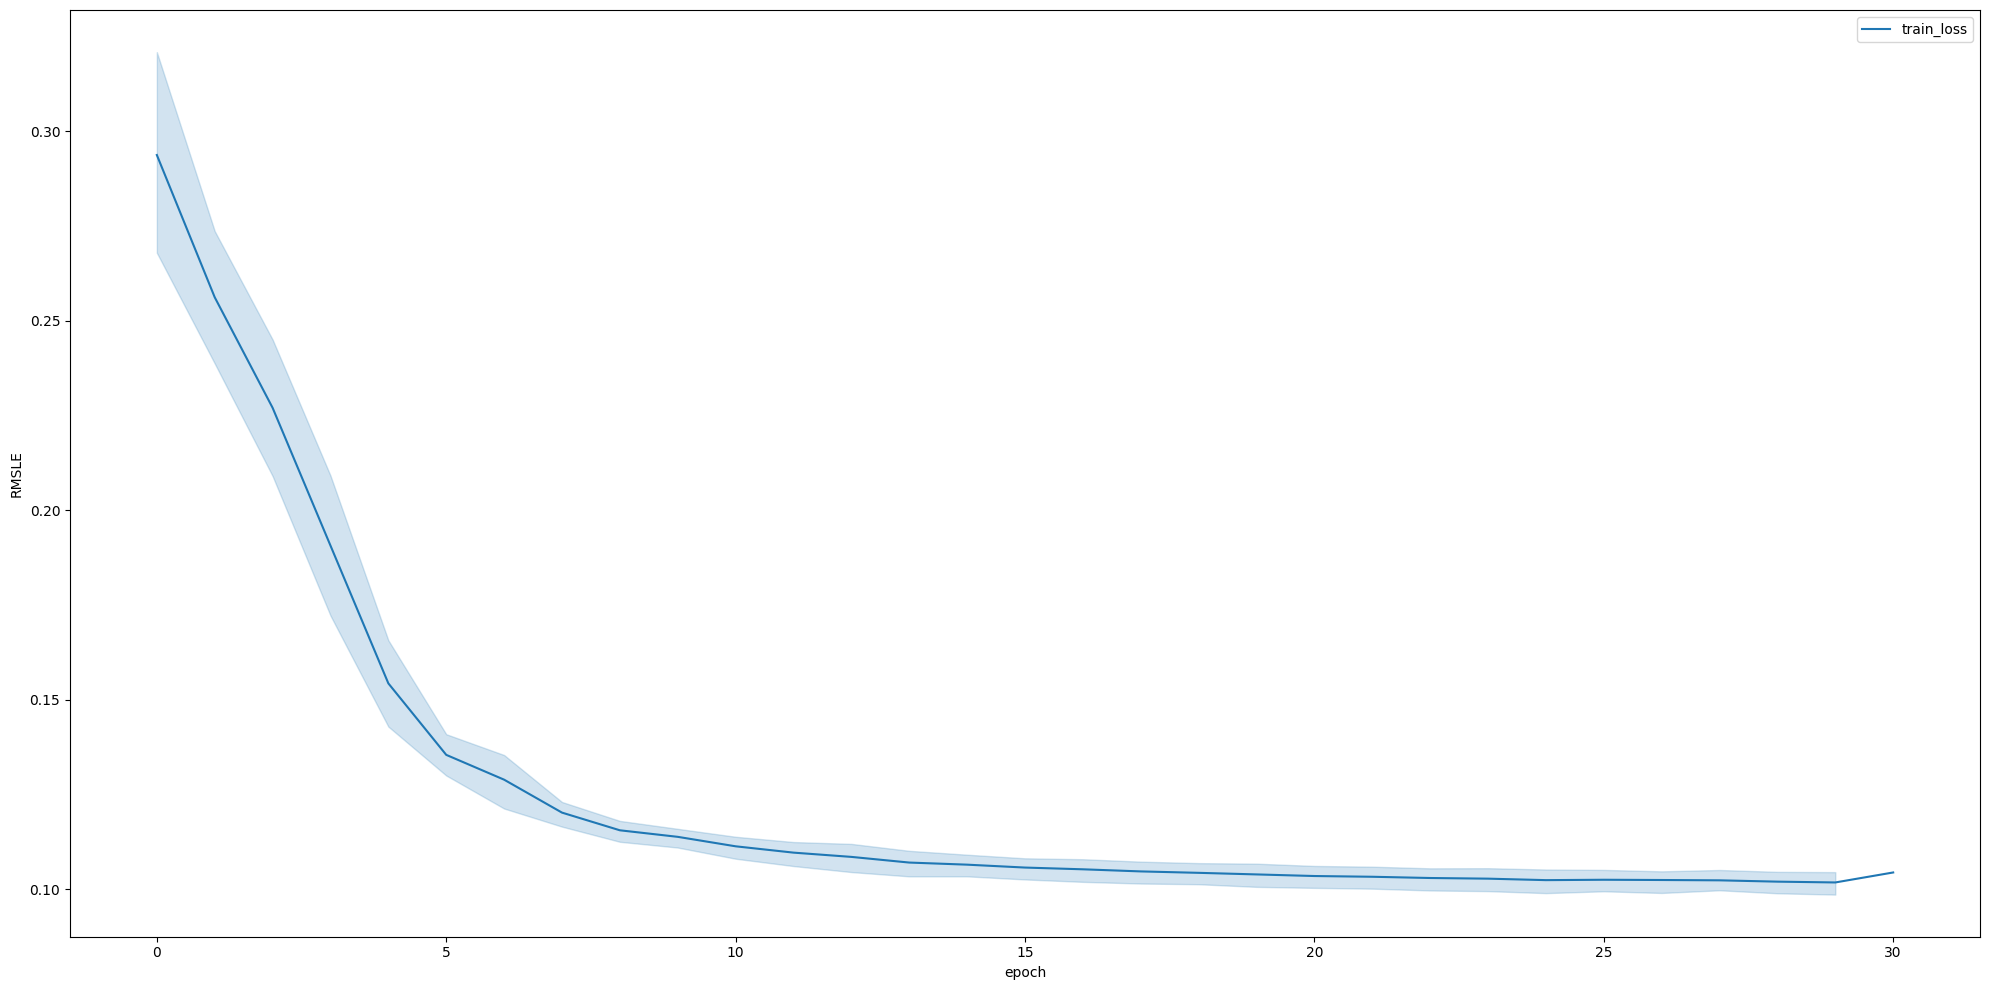

In [ ]:
plot_metrics(load_pl_logs(project_name='prediction'), x='epoch')

In [ ]:
def get_inverse_transformed_forecast(model, trainer, datamodule, num_days_past=4*7,
                                     target_columns=sales_columns,
                                     id_columns=id_columns):
  include_columns = ['date', 'store_nbr']
  train = datamodule.get_transformed_train(num_days_past)
  train_pred = train[include_columns].copy()
  forecast = datamodule.get_transformed_pred()[
      include_columns + id_columns].copy()
  model.reset_recurrent_hidden_state()
  train_pred[target_columns] = np.concatenate(trainer.predict(
      model, dataloaders=datamodule.train_pred_dataloader(num_days_past)), axis=0)
  forecast[target_columns] = np.concatenate(trainer.predict(
      model, dataloaders=datamodule.prediction_dataloader()), axis=0)
  print('Training Loss before inversion: ', RMSLE.loss_df(train_pred, train))
  train = datamodule.inverse_transform(train, unseen=False)
  train_pred = datamodule.inverse_transform(train_pred, unseen=False)
  forecast = datamodule.inverse_transform(forecast, unseen=True)
  print('Training Loss AFTER inversion: ', RMSLE.loss_df(train_pred, train))
  return dict(train=train, train_pred=train_pred, forecast=forecast)

forecast = get_inverse_transformed_forecast(model, trainer, datamodule,
                                            num_days_past=24*7)
df = forecast['forecast']
df[(df[sales_columns]<0).any(axis=1)]

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Training Loss before inversion:  tensor(0.0996, dtype=torch.float64)
Training Loss AFTER inversion:  tensor(0.4576, dtype=torch.float64)


Empty DataFrame
Columns: [date, store_nbr, AUTOMOTIVE_id, BABY CARE_id, BEAUTY_id, BEVERAGES_id, BOOKS_id, BREAD/BAKERY_id, CELEBRATION_id, CLEANING_id, DAIRY_id, DELI_id, EGGS_id, FROZEN FOODS_id, GROCERY I_id, GROCERY II_id, HARDWARE_id, HOME AND KITCHEN I_id, HOME AND KITCHEN II_id, HOME APPLIANCES_id, HOME CARE_id, LADIESWEAR_id, LAWN AND GARDEN_id, LINGERIE_id, LIQUOR,WINE,BEER_id, MAGAZINES_id, MEATS_id, PERSONAL CARE_id, PET SUPPLIES_id, PLAYERS AND ELECTRONICS_id, POULTRY_id, PREPARED FOODS_id, PRODUCE_id, SCHOOL AND OFFICE SUPPLIES_id, SEAFOOD_id, AUTOMOTIVE_sales, BABY CARE_sales, BEAUTY_sales, BEVERAGES_sales, BOOKS_sales, BREAD/BAKERY_sales, CELEBRATION_sales, CLEANING_sales, DAIRY_sales, DELI_sales, EGGS_sales, FROZEN FOODS_sales, GROCERY I_sales, GROCERY II_sales, HARDWARE_sales, HOME AND KITCHEN I_sales, HOME AND KITCHEN II_sales, HOME APPLIANCES_sales, HOME CARE_sales, LADIESWEAR_sales, LAWN AND GARDEN_sales, LINGERIE_sales, LIQUOR,WINE,BEER_sales, MAGAZINES_sales, MEATS_sales, PERSONAL CARE_sales, PET SUPPLIES_sales, PLAYERS AND ELECTRONICS_sales, POULTRY_sales, PREPARED FOODS_sales, PRODUCE_sales, SCHOOL AND OFFICE SUPPLIES_sales, SEAFOOD_sales]
Index: []

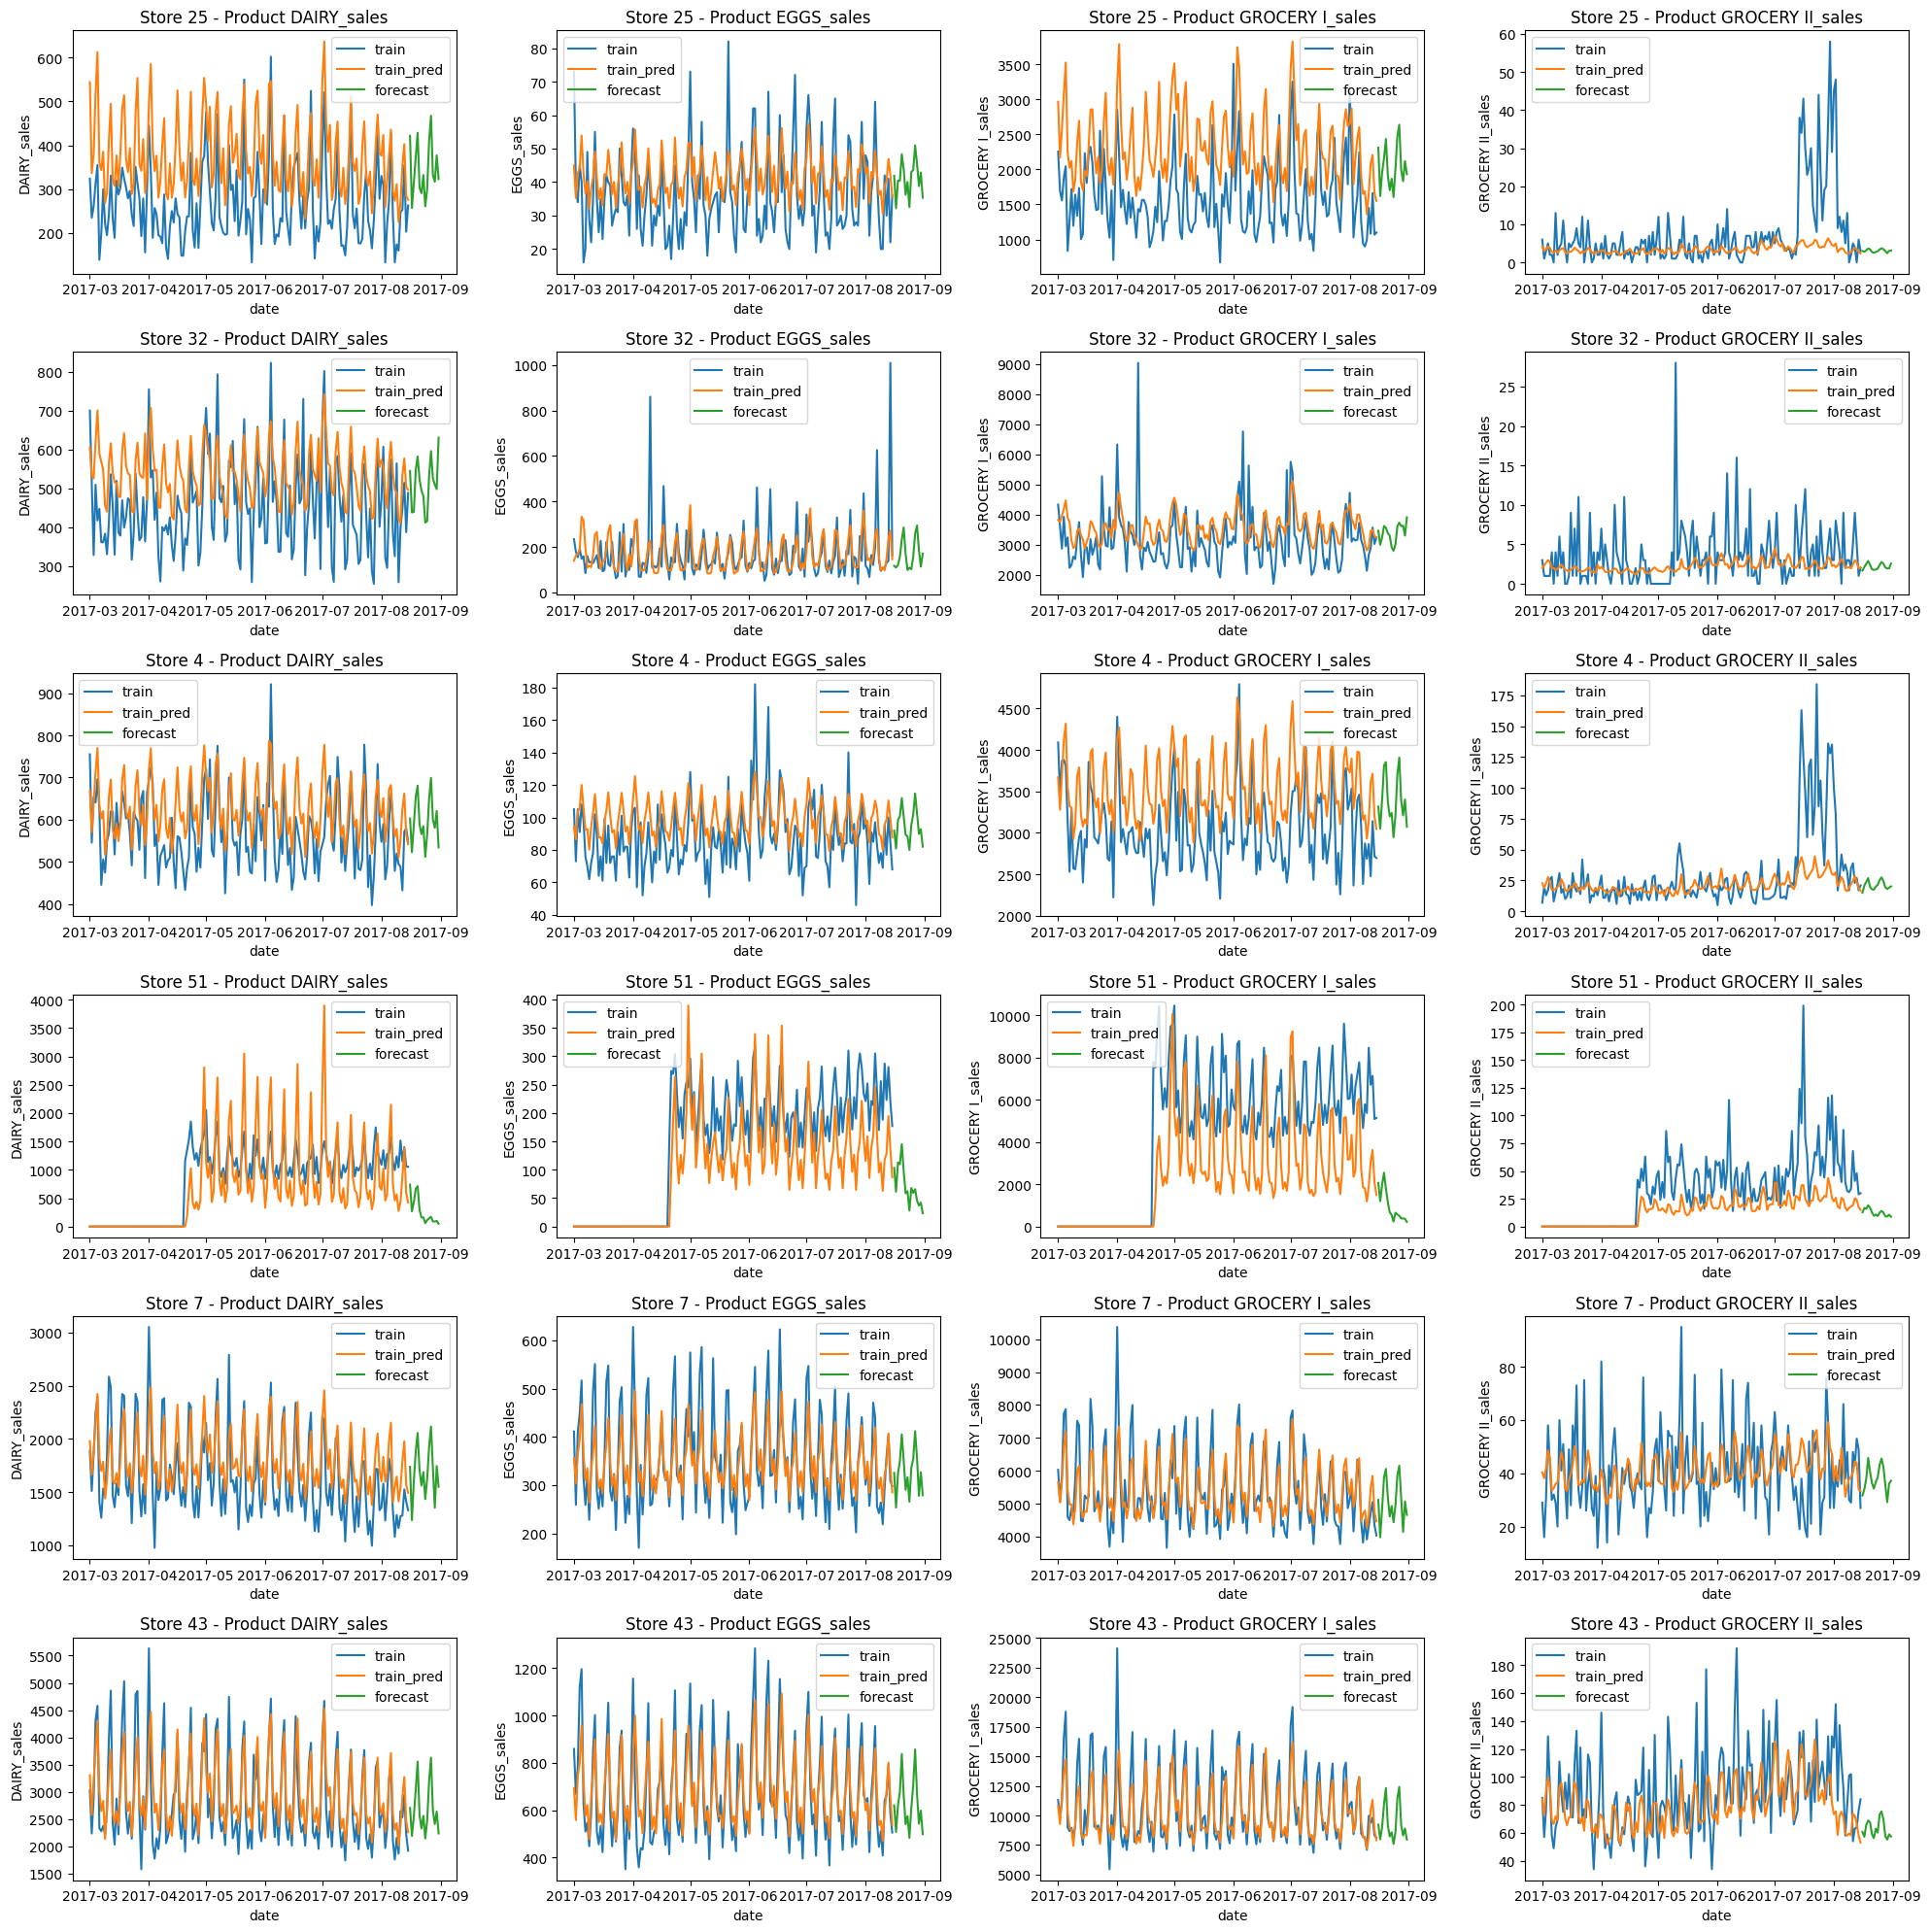

In [ ]:
show_prediction(forecast)

In [ ]:
df = forecast['forecast']
submission = pd.DataFrame(data=dict(id=pd.concat([df[col] for col in id_columns]),
             sales=pd.concat([df[col] for col in sales_columns]))).sort_values(
                 by='id')
submission.to_csv(os.path.join(
    KAGGLE_WORKING_PATH, 'submission_torch.csv'), index=False)
submission

id        sales
0    3000888     3.948193
0    3000889     0.000000
0    3000890     5.362133
0    3000891  2912.040527
0    3000892     0.080978
..       ...          ...
818  3029395   523.520691
818  3029396   110.338142
818  3029397  1351.347778
818  3029398    97.395531
818  3029399    13.132082

[28512 rows x 2 columns]

### Get Final Store Embeddings

In [ ]:
def get_store_embeddings(model, datamodule, feat_emb=feat_store_emb, feat_aux=feat_store_aux):
  df = datamodule.get_transformed_pred()
  cols = feat_emb + feat_aux
  df = df[cols].drop_duplicates()
  emb, aux = datamodule.prepare_emb_aux_tensors(df)
  model.eval()
  with torch.no_grad():
    store_emb = model.get_store_embedding(emb, aux)
  store_emb_columns = [f'store_emb_{i}' for i in range(store_emb.shape[-1])]
  df[store_emb_columns] = store_emb.cpu().numpy()
  return df

df_store_emb = get_store_embeddings(model, datamodule)
df_store_emb.to_csv(os.path.join(KAGGLE_WORKING_PATH, 'store_embedding.csv'), index=False)
df_store_emb

store_nbr  store_type  city  state  population_city  population_state  \
0          0           3    18     12         0.708104          0.524419   
1          1           3    18     12         0.708104          0.524419   
2          2           3    18     12         0.708104          0.524419   
3          3           3    18     12         0.708104          0.524419   
4          4           3    21     14        -0.759761         -1.178191   
5          5           3    18     12         0.708104          0.524419   
6          6           3    18     12         0.708104          0.524419   
7          7           3    18     12         0.708104          0.524419   
8          8           1    18     12         0.708104          0.524419   
9          9           2    18     12         0.708104          0.524419   
10        10           1     2     12        -1.058038          0.524419   
11        11           2    10      3        -1.024427         -1.193115   
12        12           2    10      3        -1.024427         -1.193115   
13        13           2    19      2        -0.921723         -1.191985   
14        14           2     9      7        -0.941527         -1.193332   
15        15           2    21     14        -0.759761         -1.178191   
16        16           2    18     12         0.708104          0.524419   
17        17           1    18     12         0.708104          0.524419   
18        18           2     7      1        -1.072222         -1.370905   
19        19           1    18     12         0.708104          0.524419   
20        20           1    21     14        -0.759761         -1.178191   
21        21           2    16     11        -1.069582         -1.428060   
22        22           3     0     15        -0.921617         -1.131921   
23        23           3     8      6         1.619593          1.378477   
24        24           3    20     13        -1.067792         -1.248508   
25        25           3     8      6         1.619593          1.378477   
26        26           3     4      6        -1.056107          1.378477   
27        27           4     8      6         1.619593          1.378477   
28        28           4     8      6         1.619593          1.378477   
29        29           2     8      6         1.619593          1.378477   
30        30           1     1      9        -1.002864         -0.912172   
31        31           2     8      6         1.619593          1.378477   
32        32           2    17      9        -0.921128         -0.912172   
33        33           1     8      6         1.619593          1.378477   
34        34           2    15      6        -1.054341          1.378477   
35        35           4    11      6        -0.988577          1.378477   
36        36           3     3      0        -0.732326         -0.975806   
37        37           3    12      8        -0.894715         -1.183140   
38        38           1     3      0        -0.732326         -0.975806   
39        39           2    13      4        -0.807805         -1.032866   
40        40           3    13      4        -0.807805         -1.032866   
41        41           3     3      0        -0.732326         -0.975806   
42        42           4     6      5        -0.944049         -1.138237   
43        43           0    18     12         0.708104          0.524419   
44        44           0    18     12         0.708104          0.524419   
45        45           0    18     12         0.708104          0.524419   
46        46           0    18     12         0.708104          0.524419   
47        47           0    18     12         0.708104          0.524419   
48        48           0    18     12         0.708104          0.524419   
49        49           0     0     15        -0.921617         -1.131921   
50        50           0     8      6         1.619593          1.378477   
51        51           0    14     10        -0.837

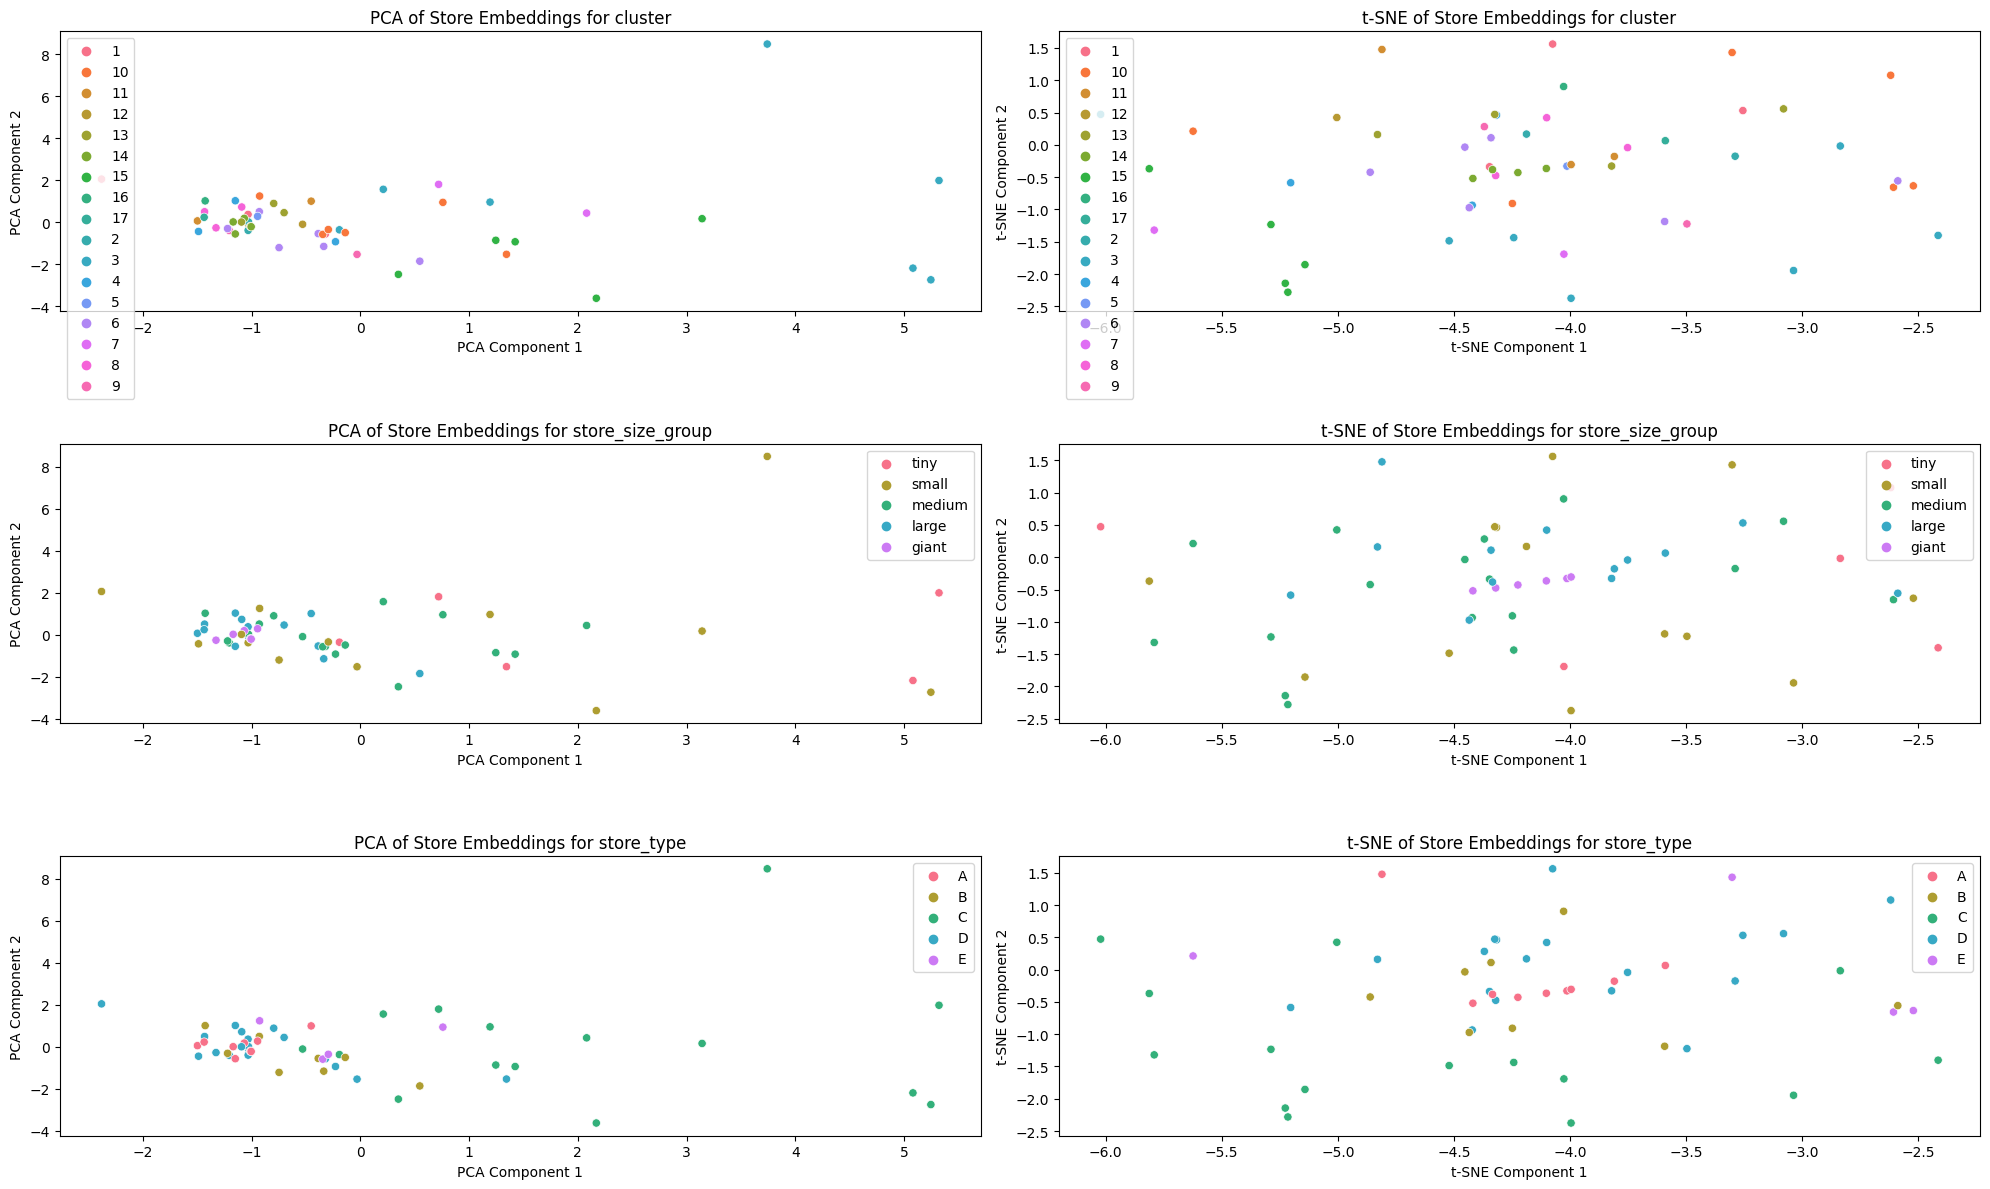

sil_score  db_index
cluster           -0.212928  2.249055
store_size_group  -0.159176  4.121713
store_type        -0.083363  3.721600

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, davies_bouldin_score
# show_dimensionality_reduced_clustering
def analyze_clustering(df, df_store_emb, cluster_columns=[
    'cluster', 'store_size_group', 'store_type']):
  df = SalesDataExtractor().merge_source_data(df)[
    ['store_nbr'] + cluster_columns].drop_duplicates().sort_values(by='store_nbr')
  df_store_emb = df_store_emb.sort_values(by='store_nbr')
  store_emb_columns = [col for col in list(df_store_emb.columns) if col.startswith('store_emb')]
  embeddings = df_store_emb[store_emb_columns].values
  sil_score = [silhouette_score(embeddings, df[col].values) for col in cluster_columns]
  db_index = [davies_bouldin_score(embeddings, df[col].values) for col in cluster_columns]
  # Visualize 2D Dimensionality reduction using Principal-Components
  # t-distributed stochastic neighbor embedding
  embeddings_pca = PCA(n_components=2).fit_transform(embeddings)
  embeddings_tsne = TSNE(n_components=2, random_state=SEED).fit_transform(embeddings)
  nrows = len(cluster_columns)
  fig, ax = plt.subplots(ncols=2, nrows=nrows, figsize=(20, 4*nrows))
  for i, col in enumerate(cluster_columns):
    clusters = df[col].values
    ax_i = ax[i,0]
    sns.scatterplot(x=embeddings_pca[:, 0], y=embeddings_pca[:, 1],
                  hue=clusters, palette='husl', legend='full', ax=ax_i)
    ax_i.set_title(f'PCA of Store Embeddings for {col}')
    ax_i.set_xlabel('PCA Component 1')
    ax_i.set_ylabel('PCA Component 2')
    ax_i = ax[i,1]
    sns.scatterplot(x=embeddings_tsne[:, 0], y=embeddings_tsne[:, 1],
                  hue=clusters, palette='husl', legend='full', ax=ax_i)
    ax_i.set_title(f't-SNE of Store Embeddings for {col}')
    ax_i.set_xlabel('t-SNE Component 1')
    ax_i.set_ylabel('t-SNE Component 2')
  plt.tight_layout()
  plt.show()
  return pd.DataFrame(index=cluster_columns,
                      data=dict(sil_score=sil_score, db_index=db_index))
analyze_clustering(df_test, df_store_emb)

In [ ]:
! ls -la

total 9520
drwxr-xr-x 3 root root    4096 Jul  3 21:27 .
drwxr-xr-x 6 root root    4096 Jul  3 21:19 ..
---------- 1 root root 8976870 Jul  3 21:27 __notebook__.ipynb
drwxr-xr-x 4 root root    4096 Jul  3 21:24 logs
-rw-r--r-- 1 root root   18127 Jul  3 21:27 store_embedding.csv
-rw-r--r-- 1 root root  734959 Jul  3 21:27 submission_torch.csv
